In [59]:
import plot_settings 
from Isochrone import * 
import functions as fun

class Cluster:
    def __init__(self, FeH, logage, Av, distance, Mcluster, seed=None):
        
        self.FeH = FeH
        self.logage = logage
        self.Av = Av
        self.dMod = fun.d_to_m(distance)
        self.Mcluster = Mcluster
        self.distance = distance
        if seed!= None: np.random.seed(seed)

        self.isochrone = Isochrone(FeH      = self.FeH,
                                   logage   = self.logage,
                                   Av       = self.Av,
                                   distance = distance)
        self.isochrone.filter_isochrone()
        self.iso_data = self.isochrone.get_data()

        # Initialize interpolation functions
        self.dictionaries()
        self.interpolation_functions = self.initialize_interpolation_functions()
        self.error_functions = self.setup_photometric_error_functions()

    def dictionaries(self):
        self.dictionary_interpolation = {
            'f_G': 'MG',
            'f_BP': 'MBP',
            'f_RP': 'MRP',
            'f_Mact': 'Mact',
            'f_Teff': 'Teff',
            'f_u': 'Mu',
            'f_b': 'Mb',
            'f_v': 'Mv',
            'f_r': 'Mr',
            'f_i': 'Mi'
        }
        
        # Define a mapping of attribute suffixes to corresponding extinction functions
        self.photometric_bands = {
            'G': self.isochrone.f_ext_G,
            'BP': self.isochrone.f_ext_BP,
            'RP': self.isochrone.f_ext_RP,
            'u': self.isochrone.f_ext_u,
            'b': self.isochrone.f_ext_b,
            'v': self.isochrone.f_ext_v,
            'r': self.isochrone.f_ext_r,
            'i': self.isochrone.f_ext_i
        }

    def setup_photometric_error_functions(self):

        sss = pd.read_csv('Gaia_DR3_phot_uncertanties/LogErrVsMagSpline.csv')

        x_G = sss['knots_G'].values
        y_G = sss['coeff_G'].values

        y_G[3] = np.mean(y_G[0:4])
        x_G[:3]= np.nan
        y_G[:3]= np.nan
        x_G[-4:] = np.nan
        y_G[-4:] = np.nan

        x_BP= sss['knots_BP'].values
        y_BP= sss['coeff_BP'].values

        x_BP = x_BP[3:-16]
        y_BP = y_BP[3:-16]

        x_RP= sss['knots_RP'].values
        y_RP= sss['coeff_RP'].values

        x_RP = x_RP[3:-16]
        y_RP = y_RP[3:-16]

        f_G_err = interpolate.interp1d(x_G[3:-4], 10**y_G[3:-4], kind='quadratic',bounds_error=False, fill_value=np.mean(10**y_G[3:15]))
        f_BP_err= interpolate.interp1d(x_BP, 10**y_BP, kind='quadratic',bounds_error=False          , fill_value=np.mean(10**y_BP[:5]))
        f_RP_err= interpolate.interp1d(x_RP, 10**y_RP, kind='quadratic',bounds_error=False          , fill_value=np.mean(10**y_RP[:5]))

        unc_synthetic = pd.read_csv('Gaia_DR3_phot_uncertanties/uncertanties_synthetic.csv')

        sigma_b = np.zeros(unc_synthetic.G.values.shape[0])
        sigma_v = np.zeros(unc_synthetic.G.values.shape[0])
        sigma_r = np.zeros(unc_synthetic.G.values.shape[0])
        sigma_i = np.zeros(unc_synthetic.G.values.shape[0])

        for i in range(unc_synthetic.G.values.shape[0]):
            sigma_b[i] = np.mean([unc_synthetic['P50(∆B)'].values[i] - unc_synthetic['P16(∆B)'].values[i], unc_synthetic['P84(∆B)'].values[i] - unc_synthetic['P50(∆B)'].values[i]])*10**(-3)
            sigma_v[i] = np.mean([unc_synthetic['P50(∆V)'].values[i] - unc_synthetic['P16(∆V)'].values[i], unc_synthetic['P84(∆V)'].values[i] - unc_synthetic['P50(∆V)'].values[i]])*10**(-3)
            sigma_r[i] = np.mean([unc_synthetic['P50(∆R)'].values[i] - unc_synthetic['P16(∆R)'].values[i], unc_synthetic['P84(∆R)'].values[i] - unc_synthetic['P50(∆R)'].values[i]])*10**(-3)
            sigma_i[i] = np.mean([unc_synthetic['P50(∆I)'].values[i] - unc_synthetic['P16(∆I)'].values[i], unc_synthetic['P84(∆I)'].values[i] - unc_synthetic['P50(∆I)'].values[i]])*10**(-3)

        sigma_b[:6] = np.full(6, np.mean(sigma_b[:6]))

        f_b_err = interpolate.interp1d(unc_synthetic.G.values, sigma_b, kind='quadratic', bounds_error=False, fill_value=0)
        f_v_err = interpolate.interp1d(unc_synthetic.G.values, sigma_v, kind='quadratic', bounds_error=False, fill_value=0)
        f_r_err = interpolate.interp1d(unc_synthetic.G.values, sigma_r, kind='quadratic', bounds_error=False, fill_value=0)
        f_i_err = interpolate.interp1d(unc_synthetic.G.values, sigma_i, kind='quadratic', bounds_error=False, fill_value=0)

        # Return the interpolation functions in a dictionary format
        error_functions = {
            'G': f_G_err,
            'BP': f_BP_err,
            'RP': f_RP_err,
            'b': f_b_err,
            'v': f_v_err,
            'r': f_r_err,
            'i': f_i_err
        }
        return error_functions

    def initialize_interpolation_functions(self):
        # Retrieve necessary data from isochrone
        # Create and store interpolation functions dynamically
        interpolation_functions = {
            key: interpolate.interp1d(self.iso_data['Mint'], self.iso_data[prop], bounds_error=False, fill_value=0)
            for key, prop in self.dictionary_interpolation.items()
        }
        return interpolation_functions
    
    def extract_masses(self):
        # Access the minimum and maximum masses from the isochrone data
        MASSES = self.iso_data['Mint']  # Assuming 'Mint' refers to initial masses
        Mmin = MASSES.min()
        Mmax = MASSES.max()

        # Define the IMF and generate masses using it
        IMF = imf.Kroupa
        selected_imf = IMF(mmin=0.03, mmax=Mmax)

        # Generate the initial mass distribution for the cluster
        mass_ext = imf.make_cluster(self.Mcluster, massfunc=selected_imf, silent=True)
        mass_ext = mass_ext[mass_ext >= Mmin]

        # Ensure that the total cluster mass matches the desired value
        while (self.Mcluster - mass_ext.sum()) > (self.Mcluster * 10**(-4)):
            additional_mass = imf.make_cluster(self.Mcluster - mass_ext.sum(), massfunc=selected_imf, silent=True)
            mass_ext = np.append(mass_ext, additional_mass)
            mass_ext = mass_ext[mass_ext >= Mmin]
        
        self.Mstar = mass_ext

    def generate_photometry(self):
        # Retrieve and use interpolation functions to generate properties
        photometric_keys = ['f_G', 'f_BP', 'f_RP', 'f_u', 'f_b', 'f_v', 'f_r', 'f_i']
        
        # Interpolate temperature and actual mass
        self.Teff_s = self.interpolation_functions['f_Teff'](self.Mstar)
        self.Mact_s = self.interpolation_functions['f_Mact'](self.Mstar)
        
        # Dynamically generate photometry attributes
        for key in photometric_keys:
            photometry_name = key.split('_')[1]
            setattr(self, f"MG_{photometry_name}_s", self.interpolation_functions[key](self.Mstar))

    def add_extinction(self):
        # Apply extinction correction and add it to existing attributes
        for band, ext_func in self.photometric_bands.items():
            # Retrieve current value, apply extinction, and update the attribute
            current_value = getattr(self, f"MG_{band}_s", 0)
            updated_value = current_value + self.Av * ext_func(10**self.Teff_s)
            setattr(self, f"MG_{band}_s", updated_value)

    def add_distance(self):
        # Define a mapping of attribute suffixes to corresponding extinction functions
        photometric_bands = ['G', 'BP','RP','u','b','v','r', 'i']
        # Apply extinction correction and add it to existing attributes
        for band in photometric_bands:
            # Retrieve current value, apply extinction, and update the attribute
            current_value = getattr(self, f"MG_{band}_s", 0)
            updated_value = current_value + self.dMod
            setattr(self, f"MG_{band}_s", updated_value)

    def add_photometric_errors(self):
        # Apply extinction correction and add it to existing attributes
        for band, ext_func in self.error_functions.items():
            # Retrieve current value, apply extinction, and update the attribute
            current_value = getattr(self, f"MG_{band}_s", 0)
            updated_value = current_value + np.random.normal(0,  ext_func(self.MG_G_s))
            setattr(self, f"MG_{band}_s", updated_value)

    def get_data_(self):
        # Returns the filtered data as a dictionary
        return pd.DataFrame({
            'Mint': self.Mstar,
            'Mact': self.Mact_s,
            'MG'  : self.MG_G_s,
            'MBP': self.MG_BP_s,
            'MRP': self.MG_RP_s,
            'Teff': self.Teff_s,
            'Mu': self.MG_u_s,
            'Mb': self.MG_b_s,
            'Mv': self.MG_v_s,
            'Mr': self.MG_r_s,
            'Mi': self.MG_i_s
        }).sort_values('Mint').reset_index(drop=True)
    
    def get_data(self):
        # Returns the filtered data as a dictionary
        return pd.DataFrame({
            'Mint': self.Mstar,
            'Mact': self.Mact_s,
            'MG'  : self.MG_G_s,
            'MBP': self.MG_BP_s,
            'MRP': self.MG_RP_s,
            'Teff': self.Teff_s,
            'Mu': self.MG_u_s,
            'Mb': self.MG_b_s,
            'Mv': self.MG_v_s,
            'Mr': self.MG_r_s,
            'Mi': self.MG_i_s,
            'is_binary' : self.isbinary,
            'resolved' : self.resolved
        }).sort_values('Mint').reset_index(drop=True)
    
    def remove_synthetic_phot(self):
        w = self.MG_G_s >= 17.8

        self.MG_u_s[w] = np.nan
        self.MG_b_s[w] = np.nan
        self.MG_v_s[w] = np.nan
        self.MG_r_s[w] = np.nan
        self.MG_i_s[w] = np.nan


    def plot(self, with_iso = True):
        
        if with_iso == True:
            isochrone = Isochrone(FeH = self.FeH,
                                logage   = self.logage,
                                Av       = self.Av,
                                distance = self.distance)
            MG = self.MG_G_s
            isochrone.plot_isochrone(absolute=False, c='red', cut=MG.max())
            plt.scatter( self.MG_BP_s - self.MG_RP_s, self.MG_G_s, s=10, zorder=10)
        else:
            plt.scatter( self.MG_BP_s - self.MG_RP_s, self.MG_G_s, s=10, zorder=10)
            plt.gca().invert_yaxis()
            
    def make_cluster(self):

        
        cluster.extract_masses()
        cluster.generate_photometry() 
        cluster.add_extinction()  
        cluster.add_distance()

        cluster.add_photometric_errors()
        cluster.remove_synthetic_phot()

        self.isbinary = self.Mact_s
        self.resolved = self.Mact_s
        

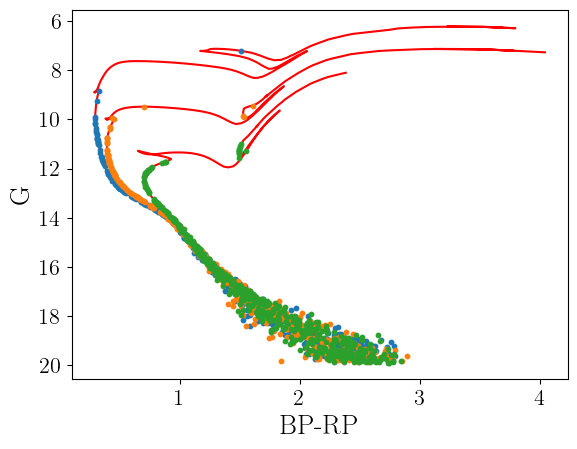

In [2]:
for age in [8,8.5,9]:

    cluster = Cluster(FeH=0.0, logage=age, Av=1, distance=1000, Mcluster=500, seed=42)
    cluster.make_cluster()
    cluster.plot(with_iso=True)

In [95]:
mass                     = np.asarray([0.10, 0.30, 1.00, 3.50, 7.00, 12.5, 16.0])
multiplicity_fraction    = np.asarray([0.22, 0.26, 0.40, 0.59, 0.76, 0.84, 0.94])
companion_star_frequency = np.asarray([0.22, 0.33, 0.50, 0.84, 1.30, 1.60, 2.10])

MF_law  = interpolate.interp1d(mass,    multiplicity_fraction, bounds_error=False, fill_value=(0.22, 0.94))
CSF_law = interpolate.interp1d(mass, companion_star_frequency, bounds_error=False, fill_value=(0.22, 2.10))

class Binaries:
    def __init__(self):
        self.MoeDiStefano()
        
    def MoeDiStefano(self):
        mass                     = np.asarray([0.10, 0.30, 1.00, 3.50, 7.00, 12.5, 16.0])
        multiplicity_fraction    = np.asarray([0.22, 0.26, 0.40, 0.59, 0.76, 0.84, 0.94])
        companion_star_frequency = np.asarray([0.22, 0.33, 0.50, 0.84, 1.30, 1.60, 2.10])

        self.MF_law  = interpolate.interp1d(mass,    multiplicity_fraction, bounds_error=False, fill_value=(0.22, 0.94))
        self.CSF_law = interpolate.interp1d(mass, companion_star_frequency, bounds_error=False, fill_value=(0.22, 2.10))

    def generate_df(df):
        mass_ext = df.Mint.values
        is_binary     = np.full(mass_ext.shape[0], False)
        ids_companion = np.full(mass_ext.shape[0], -10)
        ids = np.arange(0,mass_ext.shape[0],1)

        # With the multiplicity fraction MF we compute if a star of our population is in a binary system 
        prob_MF = MF_law(mass_ext)
        rando   = np.random.uniform(0,1,mass_ext.shape[0])
        is_binary[rando>=prob_MF] = True

        # With the CSF function we compute how many stars are companion of another
        n_companions = np.array([ np.random.poisson(1+CSF_law(m)) for m in mass_ext ])
        n_companions[~is_binary] = 0
        n_companions[n_companions>2] = 2
        n_companions[(is_binary==True)&(n_companions==0)] = 1

        # Create a pandas df to work with the binarity
        binary_pandas = {
            'mass': mass_ext,
            'is_binary': is_binary,
            'ids_companion': np.full(mass_ext.shape[0], [-10], dtype=object),
            'n_companion': n_companions,
            'q': np.full(mass_ext.shape[0], np.nan, dtype=object),  # Set dtype to object
            'fail': np.full(mass_ext.shape[0], False),
            'primary': np.full(mass_ext.shape[0], 'xxx'),
            'secondary': np.full(mass_ext.shape[0], 'xxx'),
            'A': np.full(mass_ext.shape[0], np.NaN),
            'e': np.full(mass_ext.shape[0], np.nan),
            'proj_separation': np.full(mass_ext.shape[0], np.NaN)
        }

        binary_pandas = pd.DataFrame(binary_pandas)
        
        return binary_pandas
    
    def double_binaries(binary_pandas):
        mass_ext = binary_pandas.mass.values
        ids = np.arange(0,mass_ext.shape[0],1)
    
        control = 0
        while control == 0:
            # Find candidates for binary matching
            w = ((binary_pandas['is_binary'].values == True) &
                (binary_pandas['secondary'].values == 'xxx') &
                (binary_pandas['fail'].values == False) &
                (binary_pandas['n_companion'].values == 1))
            
            # Exit the loop if fewer than 2 candidates are found
            if ids[w].shape[0] < 2:
                if ids[w].shape[0] == 1:
                    binary_pandas.loc[ids[w][0], 'fail'] = True
                break
            
            # Select a random primary candidate
            id_select = np.random.choice(ids[w])
            ids_binaries = ids[w][ids[w] != id_select]

            # Generate random mass ratios
            id_secondary = -10
            q = np.random.uniform(0, 1)

            # Calculate expected secondary mass
            m1 = mass_ext[id_select]
            m2_exp = m1 * (1 / q)

            # Find closest matching secondary star
            difference = mass_ext[ids_binaries] - m2_exp
            ww = ((difference >= -0.1) & (difference <= 0))
            
            flag = 0
            if difference[ww].shape[0] > 0:
                flag = 1
                id_secondary = ids_binaries[np.argmax(difference[ww])]

            # Update DataFrame with match results
            if flag==0:
                binary_pandas.loc[id_select, 'fail'] = True
            else:
                binary_pandas.loc[id_select, 'ids_companion'] = id_secondary
                binary_pandas.loc[id_select, 'primary'] = 'yes'
                binary_pandas.at[id_select, 'secondary'] = 'no'
                binary_pandas.loc[id_select, 'q'] = q

                binary_pandas.loc[id_secondary, 'ids_companion'] = id_select
                binary_pandas.loc[id_secondary, 'primary'] = 'no'
                binary_pandas.loc[id_secondary, 'secondary'] = 'yes'
                binary_pandas.loc[id_secondary, 'q'] = q

        return binary_pandas

    def higher_binaries(binary_pandas):
        mass_ext = binary_pandas.mass.values
        ids = np.arange(0,mass_ext.shape[0],1)

        control = 0
        while control == 0:
            # Find candidates for binary matching
            w = ((binary_pandas['is_binary'].values == True) &
                    (binary_pandas['secondary'].values == 'xxx') &
                    (binary_pandas['fail'].values == False) &
                    (binary_pandas['n_companion'].values == 2))
            
            # Exit the loop if fewer than 2 candidates are found
            if ids[w].shape[0] < 2:
                if ids[w].shape[0] == 1:
                    binary_pandas.loc[ids[w][0], 'fail'] = True
                break
            
            # Select a random primary candidate
            id_select = np.random.choice(ids[w])
            ids_binaries = ids[w][ids[w] != id_select]

            # Generate random mass ratios
            q = np.random.uniform(0, 1)
            id_secondary = -10

            # Calculate expected secondary mass
            m1 = mass_ext[id_select]
            m2_exp = m1 * (1 / q)

            # Find closest matching secondary star
            difference = mass_ext[ids_binaries] - m2_exp

            data = pd.DataFrame({
                            "ids_binaries": ids_binaries,
                            "difference": difference})
            sorted_data = data.sort_values(by="difference", ascending=True).reset_index(drop=True)

            ww = ((difference >= -0.01) & (difference <= 0))
            
            flag = 1
            if difference[ww].shape[0] > 1:
                id_secondary = sorted_data.ids_binaries.values[ww][:2]
                flag = 0
                
            # Update DataFrame with match results
            if flag == 1:
                    binary_pandas.at[id_select, 'fail'] = True
            else:
                    binary_pandas.at[id_select, 'ids_companion'] = id_secondary
                    binary_pandas.at[id_select, 'primary']   = 'yes'
                    binary_pandas.at[id_select, 'secondary'] = 'no'
                    binary_pandas.at[id_select, 'q'] = q

                    binary_pandas.at[id_secondary[0], 'ids_companion'] = [id_select, id_secondary[1]]
                    binary_pandas.at[id_secondary[0], 'primary'] = 'no'
                    binary_pandas.at[id_secondary[0], 'secondary'] = 'yes'
                    binary_pandas.at[id_secondary[0], 'q'] = q

                    binary_pandas.at[id_secondary[1], 'ids_companion'] = [id_select, id_secondary[0]]
                    binary_pandas.at[id_secondary[1], 'primary'] = 'no'
                    binary_pandas.at[id_secondary[1], 'secondary'] = 'yes'
                    binary_pandas.at[id_secondary[1], 'q'] = q

        return binary_pandas

    def generate_parameters(self, binary_pandas):
        
        mass_ext = binary_pandas.mass.values
        ids = np.arange(0,mass_ext.shape[0],1)
    
        w = (binary_pandas.primary == 'yes')#&(binary_pandas['n_companion'] == 1)
        ids_primaries = ids[w]

        masses = binary_pandas.iloc[ids_primaries]['mass'].values
        binary_pandas.loc[ids_primaries, 'A'] = fun.logsemimajoraxis(masses)
        binary_pandas.loc[ids_primaries, 'e'] = fun.generate_eccentricities(masses.shape[0])

        A = binary_pandas.iloc[ids_primaries]['A'].values
        e = binary_pandas.iloc[ids_primaries]['e'].values

        binary_pandas.loc[ids_primaries, 'proj_separation'] = fun.generate_physical_separation(A,e)
    
        proj_separation = binary_pandas.iloc[ids_primaries]['proj_separation'].values

        binary_pandas.loc[ids_primaries, 'ang_sep'] = fun.angular_separation_au_pc(proj_separation, self.distance)

        w = (binary_pandas.primary == 'yes')&(binary_pandas['ang_sep'].values>0.6)
        ids_resolved = ids[w]
        binary_pandas.loc[ids_resolved, 'resolved'] = 'yes'

        w = (binary_pandas.primary == 'yes')&(binary_pandas['ang_sep'].values<=0.6)
        ids_resolved = ids[w]
        binary_pandas.loc[ids_resolved, 'resolved'] = 'no'
        
        return binary_pandas 

    def match_binaries(binary_pandas):
        
        binary_pandas = Binaries.double_binaries(binary_pandas)
        binary_pandas = Binaries.higher_binaries(binary_pandas)

        return binary_pandas

    def update_variables(cluster,df):
        cluster.Mstar    = df['Mint'].values
        cluster.Mact_s   = df['Mact'].values
        cluster.MG_G_s   = df['MG'].values
        cluster.MG_BP_s  = df['MBP'].values
        cluster.MG_RP_s  = df['MRP'].values
        cluster.Teff_s   = df['Teff'].values
        cluster.MG_u_s   = df['Mu'].values
        cluster.MG_b_s   = df['Mb'].values
        cluster.MG_v_s   = df['Mv'].values
        cluster.MG_r_s   = df['Mr'].values
        cluster.MG_i_s   = df['Mi'].values
        cluster.isbinary = df['is_binary'].values
        cluster.resolved = df['resolved'].values


    def compute_photometry(df, cluster, binary_pandas):
        
        def combine_fluxes(primary_id, secondary_ids, band):
            # Convert magnitudes to fluxes for the primary star
            primary_flux = fun.mag_to_flux(getattr(cluster, f'MG_{band}_s')[primary_id], band)
            # Sum the fluxes of secondary companions
            total_flux = primary_flux + sum(
                fun.mag_to_flux(getattr(cluster, f'MG_{band}_s')[sec_id], band) for sec_id in secondary_ids
            )
            # Convert back to magnitude
            return fun.flux_to_mag(total_flux, band)

        # Initialize combined arrays
        MG_s_combined  = np.copy(cluster.MG_G_s)
        MBP_s_combined = np.copy(cluster.MG_BP_s)
        MRP_s_combined = np.copy(cluster.MG_RP_s)
        
        # Get the IDs to loop through
        ids = np.arange(0, df.Mint.shape[0], 1)

        # Iterate over binaries with 1 companion
        for nnn in ids[(binary_pandas.primary.values == 'yes') & 
                    (binary_pandas.resolved.values == 'no') & 
                    (binary_pandas.n_companion.values == 1)]:

            # Get the companion ID
            id_secondary = [binary_pandas.ids_companion.values[nnn]]
            
            # Compute combined magnitudes
            MG_s_combined[nnn]  = combine_fluxes(nnn, id_secondary, 'G')
            MBP_s_combined[nnn] = combine_fluxes(nnn, id_secondary, 'BP')
            MRP_s_combined[nnn] = combine_fluxes(nnn, id_secondary, 'RP')
            
            # Mark secondary star as NaN
            MG_s_combined[id_secondary]  = np.nan
            MBP_s_combined[id_secondary] = np.nan
            MRP_s_combined[id_secondary] = np.nan

        # Iterate over binaries with 2 companions
        for nnn in ids[(binary_pandas.primary.values == 'yes') & 
                    (binary_pandas.resolved.values == 'no') & 
                    (binary_pandas.n_companion.values == 2)]:

            # Get the companion IDs
            id_secondary1, id_secondary2 = binary_pandas.ids_companion.values[nnn]

            # Compute combined magnitudes
            MG_s_combined[nnn]  = combine_fluxes(nnn, [id_secondary1, id_secondary2], 'G')
            MBP_s_combined[nnn] = combine_fluxes(nnn, [id_secondary1, id_secondary2], 'BP')
            MRP_s_combined[nnn] = combine_fluxes(nnn, [id_secondary1, id_secondary2], 'RP')
            
            # Mark secondary stars as NaN
            MG_s_combined[[id_secondary1, id_secondary2]]  = np.nan
            MBP_s_combined[[id_secondary1, id_secondary2]] = np.nan
            MRP_s_combined[[id_secondary1, id_secondary2]] = np.nan

        # Update the DataFrame
        df['MG']  = MG_s_combined
        df['MBP'] = MBP_s_combined
        df['MRP'] = MRP_s_combined

        return df

    
    def make_binaries(self, cluster):
        # Get data from the provided Cluster instance
        df = cluster.get_data_()
        self.distance = cluster.distance
        
        binary_pandas = Binaries.generate_df(df)
        binary_pandas = Binaries.match_binaries(binary_pandas)

        binary_pandas = Binaries.generate_parameters(self,binary_pandas)

        df = Binaries.compute_photometry(df, cluster, binary_pandas)
        
        merged_df = pd.merge(df, binary_pandas, left_index=True, right_index=True)

        merged_df = merged_df.dropna(subset='MG')

        Binaries.update_variables(cluster, merged_df)

    

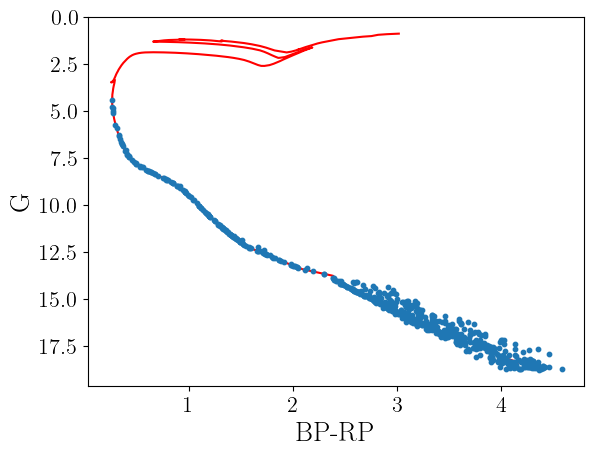

In [106]:
cluster = Cluster(FeH=0.0, logage=7.8, Av=1, distance=100, Mcluster=400)#, seed=42)
cluster.make_cluster()
before = cluster.get_data()

binaries = Binaries()
binaries.make_binaries(cluster)
after = cluster.get_data()
cluster.plot()

In [63]:
after

,Mint,Mact,MG,MBP,MRP,Teff,Mu,Mb,Mv,Mr,Mi,is_binary,resolved
0,0.500450,0.500443,16.473590,17.074971,15.687024,3.551277,NaN,NaN,NaN,NaN,NaN,False,NaN
1,0.500662,0.500652,14.371197,14.769580,13.774777,3.551361,NaN,NaN,NaN,NaN,NaN,True,NaN
2,0.502618,0.502578,13.209545,13.570911,12.661812,3.552131,NaN,NaN,NaN,NaN,NaN,True,no
3,0.503337,0.503286,19.073843,20.279065,17.872743,3.552414,NaN,NaN,NaN,NaN,NaN,True,NaN
4,0.503692,0.503635,17.862301,18.706198,16.877531,3.552554,NaN,NaN,NaN,NaN,NaN,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,2.220648,2.219072,17.523668,18.223313,16.519991,3.699898,13.723778,12.849170,11.607401,10.874313,10.187523,True,NaN
488,2.223986,2.222305,19.650308,20.708653,18.575074,3.699801,13.710520,12.839189,11.585797,10.847084,10.211988,False,NaN
489,2.241149,2.239732,19.362118,20.575192,18.040702,3.698956,13.645481,12.793664,11.522420,10.782233,10.117054,False,NaN
490,2.248780,2.247723,17.135544,17.798948,16.286079,3.698477,13.617499,12.756560,11.475091,10.735568,10.064401,False,NaN


In [64]:
df = cluster.get_data()
df#binary_pandas



,Mint,Mact,MG,MBP,MRP,Teff,Mu,Mb,Mv,Mr,Mi
0,0.300951,0.300956,19.906363,21.637243,18.464758,3.484832,NaN,NaN,NaN,NaN,NaN
1,0.301511,0.301519,19.899409,21.886082,18.337129,3.484969,NaN,NaN,NaN,NaN,NaN
2,0.301976,0.301986,19.883258,21.794513,18.354036,3.485082,NaN,NaN,NaN,NaN,NaN
3,0.304279,0.304302,19.869427,21.705740,18.534352,3.485645,NaN,NaN,NaN,NaN,NaN
4,0.305092,0.305119,19.861200,21.822657,18.403125,3.485843,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
492,9.459628,9.455680,8.802110,8.781773,8.625044,4.385853,8.150522,8.853436,8.758914,8.658911,8.544398
493,9.847353,9.844554,8.680176,8.657780,8.503869,4.393882,8.012044,8.728078,8.636019,8.537488,8.425092
494,11.319634,11.320777,8.234738,8.205190,8.066195,4.418754,7.516011,8.269547,8.187953,8.095277,7.987632
495,13.556255,13.516830,7.557844,7.522352,7.397104,4.439232,6.795758,7.583940,7.511267,7.421721,7.320900


In [ ]:
MG_s_combined  = np.copy(MG_s)
MBP_s_combined = np.copy(MG_BP_s)
MRP_s_combined = np.copy(MG_RP_s)

ids = np.arange(0, mass_ext.shape[0], 1)
for nnn in ids[(binary_pandas.primary.values == 'yes')&(binary_pandas.resolved.values == 'no')]:

    flux_G_primary, flux_BP_primary, flux_RP_primary = mag_to_flux(MG_s[nnn], 'G'), mag_to_flux(MG_BP_s[nnn], 'BP'), mag_to_flux(MG_RP_s[nnn], 'RP')
    id_secondary = binary_pandas.ids_companion.values[nnn]
    flux_G_secondary, flux_BP_secondary, flux_RP_secondary = mag_to_flux(MG_s[id_secondary], 'G'), mag_to_flux(MG_BP_s[id_secondary], 'BP'), mag_to_flux(MG_RP_s[id_secondary], 'RP')

    MG_s_combined[nnn]  = flux_to_mag( flux_G_primary + flux_G_secondary  , 'G' )
    MBP_s_combined[nnn] = flux_to_mag( flux_BP_primary + flux_BP_secondary, 'BP')
    MRP_s_combined[nnn] = flux_to_mag( flux_RP_primary + flux_RP_secondary, 'RP')

    MG_s_combined[id_secondary]  = np.nan
    MBP_s_combined[id_secondary] = np.nan
    MRP_s_combined[id_secondary] = np.nan


In [59]:
mass_ext = df.Mint.values
is_binary     = np.full(mass_ext.shape[0], False)
ids_companion = np.full(mass_ext.shape[0], -10)
ids = np.arange(0,mass_ext.shape[0],1)

# With the multiplicity fraction MF we compute if a star of our population is in a binary system 
prob_MF = MF_law(mass_ext)
rando   = np.random.uniform(0,1,mass_ext.shape[0])
is_binary[rando>=prob_MF] = True

# With the CSF function we compute how many stars are companion of another
n_companions = np.array([ np.random.poisson(1+CSF_law(m)) for m in mass_ext ])
n_companions[~is_binary] = 0
n_companions[n_companions>2] = 2
n_companions[(is_binary==True)&(n_companions==0)] = 1

# Create a pandas df to work with the binarity
binary_pandas = {
    'mass': mass_ext,
    'is_binary': is_binary,
    'ids_companion': np.full(mass_ext.shape[0], [-10], dtype=object),
    'n_companion': n_companions,
    'q': np.full(mass_ext.shape[0], np.nan, dtype=object),  # Set dtype to object
    'fail': np.full(mass_ext.shape[0], False),
    'primary': np.full(mass_ext.shape[0], 'xxx'),
    'secondary': np.full(mass_ext.shape[0], 'xxx'),
    'A': np.full(mass_ext.shape[0], np.NaN),
    'e': np.full(mass_ext.shape[0], np.nan),
    'proj_separation': np.full(mass_ext.shape[0], np.NaN)
}

binary_pandas = pd.DataFrame(binary_pandas)

In [ ]:
import numpy as np
import pandas as pd
import random



In [ ]:
is_binary     = np.full(mass_ext.shape[0], False)
ids_companion = np.full(mass_ext.shape[0], -10)
ids = np.arange(0,mass_ext.shape[0],1)

# With the multiplicity fraction MF we compute if a star of our population is in a binary system 
prob_MF = MF_law(mass_ext)
rando   = np.random.uniform(0,1,mass_ext.shape[0])
is_binary[rando>=prob_MF] = True

# With the CSF function we compute how many stars are companion of another
n_companions = np.array([ np.random.poisson(1+CSF_law(m)) for m in mass_ext ])
n_companions[~is_binary] = 0
n_companions[n_companions>2] = 2
n_companions[(is_binary==True)&(n_companions==0)] = 1

# Create a pandas df to work with the binarity
binary_pandas = {
    'mass': mass_ext,
    'is_binary': is_binary,
    'ids_companion': np.full(mass_ext.shape[0], [-10], dtype=object),
    'n_companion': n_companions,
    'q': np.full(mass_ext.shape[0], np.nan, dtype=object),  # Set dtype to object
    'fail': np.full(mass_ext.shape[0], False),
    'primary': np.full(mass_ext.shape[0], 'xxx'),
    'secondary': np.full(mass_ext.shape[0], 'xxx'),
    'A': np.full(mass_ext.shape[0], np.NaN),
    'e': np.full(mass_ext.shape[0], np.nan),
    'proj_separation': np.full(mass_ext.shape[0], np.NaN)
}

binary_pandas = pd.DataFrame(binary_pandas)

binary_pandas = match_binaries(binary_pandas, mass_ext, ids)

binary_pandas

In [ ]:


def IMF_law(m):
    
    m1 = m[m<=0.08]
    m2 = m[(m>0.08)&(m<=0.5)]
    m3 = m[m>0.5]

    p1 = 0.3
    p2 = 1.3
    p3 = 2.3

    B = 0.5**(-p3) / 0.5**(-p2)
    A = B * (0.08**(-p2)/0.08**(-p1))


    value1 = A * m1**(-p1)
    value2 = B * m2**(-p2)
    value3 = m3**(-p3)
    norm = 12.297830547050037
    value = np.concatenate((value1, value2, value3))/norm
    return value

def load_photometric_errors():

    sss = pd.read_csv('Gaia_DR3_phot_uncertanties/LogErrVsMagSpline.csv')

    x_G = sss['knots_G'].values
    y_G = sss['coeff_G'].values

    y_G[3] = np.mean(y_G[0:4])
    x_G[:3]= np.nan
    y_G[:3]= np.nan
    x_G[-4:] = np.nan
    y_G[-4:] = np.nan

    x_BP= sss['knots_BP'].values
    y_BP= sss['coeff_BP'].values

    x_BP = x_BP[3:-16]
    y_BP = y_BP[3:-16]

    x_RP= sss['knots_RP'].values
    y_RP= sss['coeff_RP'].values

    x_RP = x_RP[3:-16]
    y_RP = y_RP[3:-16]

    f_G_err = interpolate.interp1d(x_G[3:-4], 10**y_G[3:-4], kind='quadratic',bounds_error=False, fill_value=np.mean(10**y_G[3:15]))
    f_BP_err= interpolate.interp1d(x_BP, 10**y_BP, kind='quadratic',bounds_error=False          , fill_value=np.mean(10**y_BP[:5]))
    f_RP_err= interpolate.interp1d(x_RP, 10**y_RP, kind='quadratic',bounds_error=False          , fill_value=np.mean(10**y_RP[:5]))

    unc_synthetic = pd.read_csv('Gaia_DR3_phot_uncertanties/uncertanties_synthetic.csv')

    sigma_b = np.zeros(unc_synthetic.G.values.shape[0])
    sigma_v = np.zeros(unc_synthetic.G.values.shape[0])
    sigma_r = np.zeros(unc_synthetic.G.values.shape[0])
    sigma_i = np.zeros(unc_synthetic.G.values.shape[0])

    for i in range(unc_synthetic.G.values.shape[0]):
        sigma_b[i] = np.mean([unc_synthetic['P50(∆B)'].values[i] - unc_synthetic['P16(∆B)'].values[i], unc_synthetic['P84(∆B)'].values[i] - unc_synthetic['P50(∆B)'].values[i]])*10**(-3)
        sigma_v[i] = np.mean([unc_synthetic['P50(∆V)'].values[i] - unc_synthetic['P16(∆V)'].values[i], unc_synthetic['P84(∆V)'].values[i] - unc_synthetic['P50(∆V)'].values[i]])*10**(-3)
        sigma_r[i] = np.mean([unc_synthetic['P50(∆R)'].values[i] - unc_synthetic['P16(∆R)'].values[i], unc_synthetic['P84(∆R)'].values[i] - unc_synthetic['P50(∆R)'].values[i]])*10**(-3)
        sigma_i[i] = np.mean([unc_synthetic['P50(∆I)'].values[i] - unc_synthetic['P16(∆I)'].values[i], unc_synthetic['P84(∆I)'].values[i] - unc_synthetic['P50(∆I)'].values[i]])*10**(-3)

    sigma_b[:6] = np.full(6, np.mean(sigma_b[:6]))

    f_b_err = interpolate.interp1d(unc_synthetic.G.values, sigma_b, kind='quadratic', bounds_error=False, fill_value=0)
    f_v_err = interpolate.interp1d(unc_synthetic.G.values, sigma_v, kind='quadratic', bounds_error=False, fill_value=0)
    f_r_err = interpolate.interp1d(unc_synthetic.G.values, sigma_r, kind='quadratic', bounds_error=False, fill_value=0)
    f_i_err = interpolate.interp1d(unc_synthetic.G.values, sigma_i, kind='quadratic', bounds_error=False, fill_value=0)

    return f_G_err, f_BP_err, f_RP_err, f_b_err, f_v_err, f_r_err, f_i_err

def extract_masses(IMF, MASSES,f_IMF, Nstars, Mcluster):

    #22-Oct-2024

    Mmin = MASSES.min()
    if Nstars == None:
        IMF = imf.Kroupa
        selected_imf = IMF(mmin=0.03, mmax=MASSES.max())

        mass_ext = imf.make_cluster(Mcluster, massfunc=selected_imf, silent=True)
        mass_ext = mass_ext[mass_ext>=Mmin]

        while ((Mcluster-mass_ext.sum())>(Mcluster*10**(-4))):
            mass_ext = np.append(mass_ext,imf.make_cluster(Mcluster-mass_ext.sum(), massfunc=selected_imf, silent=True))
            mass_ext = mass_ext[mass_ext>=Mmin]
        
    if Mcluster == None:

        rand = np.random.uniform(0,1,Nstars)
        ext = f_IMF(rand)

        mass_ext = ext
    
    return mass_ext

def cut_isochrone(MG, d, Av, f_ext_G, Teff, Mlimit=18):
    limit = MG + d + Av*f_ext_G(10**Teff)   
    w = limit<=(Mlimit+0.1)
    return w

def load_ext_curves(Av):
    with open('Extintion/G/f_av%1.2f.pkl' % Av, 'rb') as file:
        f_ext_G = pickle.load(file)
    with open('Extintion/BP/f_av%1.2f.pkl' % Av, 'rb') as file:
        f_ext_BP = pickle.load(file)
    with open('Extintion/RP/f_av%1.2f.pkl' % Av, 'rb') as file:
        f_ext_RP = pickle.load(file)
    with open('Extintion/u/f_av%1.2f.pkl' % Av, 'rb') as file:
        f_ext_u = pickle.load(file)
    with open('Extintion/b/f_av%1.2f.pkl' % Av, 'rb') as file:
        f_ext_b = pickle.load(file)
    with open('Extintion/v/f_av%1.2f.pkl' % Av, 'rb') as file:
        f_ext_v = pickle.load(file)
    with open('Extintion/r/f_av%1.2f.pkl' % Av, 'rb') as file:
        f_ext_r = pickle.load(file)
    with open('Extintion/i/f_av%1.2f.pkl' % Av, 'rb') as file:
        f_ext_i = pickle.load(file)
    return f_ext_G, f_ext_BP, f_ext_RP, f_ext_u, f_ext_b, f_ext_v, f_ext_r, f_ext_i


def synthetic_cluster(logage, FeH, Av, d, Nstars=None, Mcluster=None, save=False, gen_name='xxx'):

    DF = pd.read_csv('PARSEC/ALL/%1.2f_%1.2f.csv' % (FeH, logage))

    MASSES = DF.Mini.values
    Mact   = DF.Mass.values
    MG     = DF.G.values
    MG_BP  = DF.BP.values
    MG_RP  = DF.RP.values
    Teff   = DF.logTe.values

    Mu     = DF.u.values
    Mb     = DF.b.values
    Mv     = DF.v.values
    Mr     = DF.r.values
    Mi     = DF.i.values
    
    #---------------LOAD EXTICTION CURVES-------------------------------

    f_ext_G, f_ext_BP, f_ext_RP, f_ext_u, f_ext_b, f_ext_v, f_ext_r, f_ext_i = load_ext_curves(Av)

    #---------------LOAD PHOTMOTRIC ERRORS-------------------------------

    f_G_err, f_BP_err, f_RP_err, f_b_err, f_v_err, f_r_err, f_i_err = load_photometric_errors()

    #----------------CUT THE ISOCRONE TO HAVE ALL STARS BRIGHTER THAN G=20-----------------------------------------------------

    w = cut_isochrone(MG, d, Av, f_ext_G, Teff)

    MASSES, Mact, MG, MG_BP, MG_RP, Teff = MASSES[w], Mact[w], MG[w], MG_BP[w], MG_RP[w], Teff[w]
    Mu, Mb, Mv, Mr, Mi = Mu[w], Mb[w], Mv[w], Mr[w], Mi[w]

    if MASSES.shape[0]!= 0:
        IMF = IMF_law(MASSES)
        norm_IMF = np.trapz(IMF, x=MASSES)
        IMF = IMF / norm_IMF

        integral = np.zeros(MASSES.shape[0])
        for i in range(1,MASSES.shape[0]+1):
            integral[i-1] = np.trapz(IMF[0:i], x=MASSES[0:i])

        f_IMF = interpolate.interp1d(integral,MASSES, bounds_error=False, fill_value=0)
    
    #-----------------------------------------------------------------------------------------------------------------------
        
    mass_ext = extract_masses(IMF, MASSES,f_IMF, Nstars, Mcluster)
    
    IMF = imf.Kroupa
    selected_imf = IMF(mmin=0.03, mmax=MASSES.max())
    mass_ext = imf.make_cluster(Mcluster, massfunc=selected_imf, silent=True)

    f_G    = interpolate.interp1d(MASSES,MG   , bounds_error=False, fill_value=0)
    f_BP   = interpolate.interp1d(MASSES,MG_BP, bounds_error=False, fill_value=0)
    f_RP   = interpolate.interp1d(MASSES,MG_RP, bounds_error=False, fill_value=0)
    f_Mact = interpolate.interp1d(MASSES,Mact , bounds_error=False, fill_value=0)
    f_Teff = interpolate.interp1d(MASSES,Teff , bounds_error=False, fill_value=0)

    f_u    = interpolate.interp1d(MASSES,Mu   , bounds_error=False, fill_value=0)
    f_b    = interpolate.interp1d(MASSES,Mb   , bounds_error=False, fill_value=0)
    f_v    = interpolate.interp1d(MASSES,Mv   , bounds_error=False, fill_value=0)
    f_r    = interpolate.interp1d(MASSES,Mr   , bounds_error=False, fill_value=0)
    f_i    = interpolate.interp1d(MASSES,Mi   , bounds_error=False, fill_value=0)

    Teff_s  = f_Teff(mass_ext) 
    Mact_s  = f_Mact(mass_ext)

    MG_s    = f_G(mass_ext)    + Av*f_ext_G(10**Teff_s)  + d 
    MG_BP_s = f_BP(mass_ext)   + Av*f_ext_BP(10**Teff_s) + d
    MG_RP_s = f_RP(mass_ext)   + Av*f_ext_RP(10**Teff_s) + d
    
    MG_u_s = f_u(mass_ext)   + Av*f_ext_u(10**Teff_s) + d
    MG_b_s = f_b(mass_ext)   + Av*f_ext_b(10**Teff_s) + d
    MG_v_s = f_v(mass_ext)   + Av*f_ext_v(10**Teff_s) + d
    MG_r_s = f_r(mass_ext)   + Av*f_ext_r(10**Teff_s) + d
    MG_i_s = f_i(mass_ext)   + Av*f_ext_i(10**Teff_s) + d

    #----------------------ADD PHOTOMETRIC ERRORS-----------------------------------------------------------------------------

    MG_s    += np.random.normal(0,  f_G_err(MG_s))
    MG_BP_s += np.random.normal(0,  f_BP_err(MG_s))
    MG_RP_s += np.random.normal(0,  f_RP_err(MG_s))

    Mini_s = mass_ext

    www = MG_s >= 17.6
    MG_u_s[www] = np.nan
    MG_b_s[www] = np.nan
    MG_v_s[www] = np.nan
    MG_r_s[www] = np.nan
    MG_i_s[www] = np.nan

    MG_b_s[~www]+= np.random.normal(0,f_b_err(MG_s[~www])) 
    MG_v_s[~www]+= np.random.normal(0,f_v_err(MG_s[~www])) 
    MG_r_s[~www]+= np.random.normal(0,f_r_err(MG_s[~www])) 
    MG_i_s[~www]+= np.random.normal(0,f_i_err(MG_s[~www])) 
    

    df = {'Mini': Mini_s.round(6), 'Mact': Mact_s.round(6), 'G': MG_s.round(3), 'BP': MG_BP_s.round(3), 'RP': MG_RP_s.round(3), 'u' : MG_u_s.round(3), 'b' : MG_b_s.round(3), 'v' : MG_v_s.round(3), 'r' : MG_r_s.round(3), 'i' : MG_i_s.round(3)}
    CMD = pd.DataFrame(df)
    CMD = CMD[((CMD.BP.values-CMD.RP.values)<6.5)] 
    
    Nstars_gaia = int(CMD.G.values.shape[0])
    Nstars_synt = int(CMD.b.values[~np.isnan(CMD.b.values)].shape[0])

    name_file = '%1.2f_%1.1f_%1.2f_%1.2f_%d_%d.csv' % (logage, FeH, Av, d, Nstars_gaia, Nstars_synt)

    if save == True:
        CMD.to_csv('SYNTHETIC_CMDs/%s/' % (gen_name) + name_file, index=False)

    return CMD

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def d_to_m(d):
    m = 5*np.log10(d) - 5
    return m

def m_to_d(m):
    d = 10**(1+m/5)
    return d

def IMF_law(m):
    
    m1 = m[m<=0.08]
    m2 = m[(m>0.08)&(m<=0.5)]
    m3 = m[m>0.5]

    p1 = 0.3
    p2 = 1.3
    p3 = 2.3

    B = 0.5**(-p3) / 0.5**(-p2)
    A = B * (0.08**(-p2)/0.08**(-p1))


    value1 = A * m1**(-p1)
    value2 = B * m2**(-p2)
    value3 = m3**(-p3)
    norm = 12.297830547050037
    value = np.concatenate((value1, value2, value3))/norm
    return value

def load_photometric_errors():

    sss = pd.read_csv('Gaia_DR3_phot_uncertanties/LogErrVsMagSpline.csv')

    x_G = sss['knots_G'].values
    y_G = sss['coeff_G'].values

    y_G[3] = np.mean(y_G[0:4])
    x_G[:3]= np.nan
    y_G[:3]= np.nan
    x_G[-4:] = np.nan
    y_G[-4:] = np.nan

    x_BP= sss['knots_BP'].values
    y_BP= sss['coeff_BP'].values

    x_BP = x_BP[3:-16]
    y_BP = y_BP[3:-16]

    x_RP= sss['knots_RP'].values
    y_RP= sss['coeff_RP'].values

    x_RP = x_RP[3:-16]
    y_RP = y_RP[3:-16]

    f_G_err = interpolate.interp1d(x_G[3:-4], 10**y_G[3:-4], kind='quadratic',bounds_error=False, fill_value=np.mean(10**y_G[3:15]))
    f_BP_err= interpolate.interp1d(x_BP, 10**y_BP, kind='quadratic',bounds_error=False          , fill_value=np.mean(10**y_BP[:5]))
    f_RP_err= interpolate.interp1d(x_RP, 10**y_RP, kind='quadratic',bounds_error=False          , fill_value=np.mean(10**y_RP[:5]))

    unc_synthetic = pd.read_csv('Gaia_DR3_phot_uncertanties/uncertanties_synthetic.csv')

    sigma_b = np.zeros(unc_synthetic.G.values.shape[0])
    sigma_v = np.zeros(unc_synthetic.G.values.shape[0])
    sigma_r = np.zeros(unc_synthetic.G.values.shape[0])
    sigma_i = np.zeros(unc_synthetic.G.values.shape[0])

    for i in range(unc_synthetic.G.values.shape[0]):
        sigma_b[i] = np.mean([unc_synthetic['P50(∆B)'].values[i] - unc_synthetic['P16(∆B)'].values[i], unc_synthetic['P84(∆B)'].values[i] - unc_synthetic['P50(∆B)'].values[i]])*10**(-3)
        sigma_v[i] = np.mean([unc_synthetic['P50(∆V)'].values[i] - unc_synthetic['P16(∆V)'].values[i], unc_synthetic['P84(∆V)'].values[i] - unc_synthetic['P50(∆V)'].values[i]])*10**(-3)
        sigma_r[i] = np.mean([unc_synthetic['P50(∆R)'].values[i] - unc_synthetic['P16(∆R)'].values[i], unc_synthetic['P84(∆R)'].values[i] - unc_synthetic['P50(∆R)'].values[i]])*10**(-3)
        sigma_i[i] = np.mean([unc_synthetic['P50(∆I)'].values[i] - unc_synthetic['P16(∆I)'].values[i], unc_synthetic['P84(∆I)'].values[i] - unc_synthetic['P50(∆I)'].values[i]])*10**(-3)

    sigma_b[:6] = np.full(6, np.mean(sigma_b[:6]))

    f_b_err = interpolate.interp1d(unc_synthetic.G.values, sigma_b, kind='quadratic', bounds_error=False, fill_value=0)
    f_v_err = interpolate.interp1d(unc_synthetic.G.values, sigma_v, kind='quadratic', bounds_error=False, fill_value=0)
    f_r_err = interpolate.interp1d(unc_synthetic.G.values, sigma_r, kind='quadratic', bounds_error=False, fill_value=0)
    f_i_err = interpolate.interp1d(unc_synthetic.G.values, sigma_i, kind='quadratic', bounds_error=False, fill_value=0)

    return f_G_err, f_BP_err, f_RP_err, f_b_err, f_v_err, f_r_err, f_i_err

def extract_masses(IMF, MASSES,f_IMF, Nstars, Mcluster):
    
    #3-Oct-2024
    Mmin = MASSES.min()
    if Nstars == None:
        IMF = imf.Kroupa
        selected_imf = IMF(mmin=0.03, mmax=MASSES.max())

        mass_ext = imf.make_cluster(Mcluster, massfunc=selected_imf, silent=True)
        mass_ext = mass_ext[mass_ext>=Mmin]

        while ((Mcluster-mass_ext.sum())>(Mcluster*10**(-4))):
            mass_ext = np.append(mass_ext,imf.make_cluster(Mcluster-mass_ext.sum(), massfunc=selected_imf, silent=True))
            mass_ext = mass_ext[mass_ext>=Mmin]
        
        # M_mean = np.trapz(MASSES*IMF, x=MASSES)

        # N_stars = int(Mcluster/M_mean)
        # out = np.array([0])

        # while abs(np.sum(out)-Mcluster)>1:
        #     rand = np.random.uniform(0,1,N_stars)
        #     ext = f_IMF(rand)

        #     mass_norm = ext / ext.sum()
        #     out = mass_norm * Mcluster

        #     out = np.maximum(out, np.amin(MASSES))
        #     out = np.minimum(out, np.amax(MASSES))
        
        # mass_ext = out
    if Mcluster == None:

        rand = np.random.uniform(0,1,Nstars)
        ext = f_IMF(rand)

        mass_ext = ext
    
    return mass_ext

def extract_masses(MASSES, Nstars, Mcluster):
    
    #21-Oct-2024
    Mmin = MASSES.min()
    if Nstars == None:
        IMF = imf.Kroupa
        selected_imf = IMF(mmin=0.03, mmax=MASSES.max())

        mass_ext = imf.make_cluster(Mcluster, massfunc=selected_imf, silent=True)
        mass_ext = mass_ext[mass_ext>=Mmin]

        while ((Mcluster-mass_ext.sum())>(Mcluster*10**(-4))):
            mass_ext = np.append(mass_ext,imf.make_cluster(Mcluster-mass_ext.sum(), massfunc=selected_imf, silent=True))
            mass_ext = mass_ext[mass_ext>=Mmin]
        
        # M_mean = np.trapz(MASSES*IMF, x=MASSES)

        # N_stars = int(Mcluster/M_mean)
        # out = np.array([0])

        # while abs(np.sum(out)-Mcluster)>1:
        #     rand = np.random.uniform(0,1,N_stars)
        #     ext = f_IMF(rand)

        #     mass_norm = ext / ext.sum()
        #     out = mass_norm * Mcluster

        #     out = np.maximum(out, np.amin(MASSES))
        #     out = np.minimum(out, np.amax(MASSES))
        
        # mass_ext = out
    if Mcluster == None:

        rand = np.random.uniform(0,1,Nstars)
        #ext = f_IMF(rand)

        #mass_ext = ext
    
    return mass_ext

def cut_isochrone(MG, d, Av, f_ext_G, Teff, Mlimit=20):
    limit = MG + d + Av*f_ext_G(10**Teff)   
    w = limit<=(Mlimit+0.1)
    return w

def load_ext_curves(Av):
    with open('Extintion/G/f_av%1.2f.pkl' % Av, 'rb') as file:
        f_ext_G = pickle.load(file)
    with open('Extintion/BP/f_av%1.2f.pkl' % Av, 'rb') as file:
        f_ext_BP = pickle.load(file)
    with open('Extintion/RP/f_av%1.2f.pkl' % Av, 'rb') as file:
        f_ext_RP = pickle.load(file)
    with open('Extintion/u/f_av%1.2f.pkl' % Av, 'rb') as file:
        f_ext_u = pickle.load(file)
    with open('Extintion/b/f_av%1.2f.pkl' % Av, 'rb') as file:
        f_ext_b = pickle.load(file)
    with open('Extintion/v/f_av%1.2f.pkl' % Av, 'rb') as file:
        f_ext_v = pickle.load(file)
    with open('Extintion/r/f_av%1.2f.pkl' % Av, 'rb') as file:
        f_ext_r = pickle.load(file)
    with open('Extintion/i/f_av%1.2f.pkl' % Av, 'rb') as file:
        f_ext_i = pickle.load(file)
    return f_ext_G, f_ext_BP, f_ext_RP, f_ext_u, f_ext_b, f_ext_v, f_ext_r, f_ext_i

def synthetic_cluster(logage, FeH, Av, d, Nstars=None, Mcluster=None, save=False, gen_name='xxx'):

    ### VERSION 2.0 (3-Oct-2024)
    # Add check limits of logage and FeH
    # Changed extract_masses

#---Check if logage and FeH are within the specified limits----------------------------------------------------
    logage_limits = [6.5,10.12]
    FeH_limits    = [-1.0,0.8]

    if not (logage_limits[0] <= logage <= logage_limits[1]):
        return f"Error: logage value {logage} is out of bounds. It should be between {logage_limits[0]} and {logage_limits[1]}."

    if not (FeH_limits[0] <= FeH <= FeH_limits[1]):
        return f"Error: FeH value {FeH} is out of bounds. It should be between {FeH_limits[0]} and {FeH_limits[1]}."

    # Proceed with loading the CSV file if values are within limits
    file_path = 'PARSEC/ALL/%1.2f_%1.2f.csv' % (FeH, logage)

#-------------- LOAD THE TABLES OF THE NEEDED PARSEC ISOCHRONE -----------------------
    try:
        DF = pd.read_csv(file_path)
    except FileNotFoundError:
        return f"Error: File '{file_path}' not found."

    MASSES = DF.Mini.values
    Mact   = DF.Mass.values
    MG     = DF.G.values
    MG_BP  = DF.BP.values
    MG_RP  = DF.RP.values
    Teff   = DF.logTe.values

    Mu     = DF.u.values
    Mb     = DF.b.values
    Mv     = DF.v.values
    Mr     = DF.r.values
    Mi     = DF.i.values
    
    #---------------LOAD EXTICTION CURVES-------------------------------

    f_ext_G, f_ext_BP, f_ext_RP, f_ext_u, f_ext_b, f_ext_v, f_ext_r, f_ext_i = load_ext_curves(Av)

    #---------------LOAD PHOTMOTRIC ERRORS-------------------------------

    f_G_err, f_BP_err, f_RP_err, f_b_err, f_v_err, f_r_err, f_i_err = load_photometric_errors()

    #----------------CUT THE ISOCRONE TO HAVE ALL STARS BRIGHTER THAN G=20-----------------------------------------------------

    w = cut_isochrone(MG, d, Av, f_ext_G, Teff)

    MASSES, Mact, MG, MG_BP, MG_RP, Teff = MASSES[w], Mact[w], MG[w], MG_BP[w], MG_RP[w], Teff[w]
    Mu, Mb, Mv, Mr, Mi = Mu[w], Mb[w], Mv[w], Mr[w], Mi[w]

    if MASSES.shape[0]!= 0:
        IMF = IMF_law(MASSES)
        norm_IMF = np.trapz(IMF, x=MASSES)
        IMF = IMF / norm_IMF

        integral = np.zeros(MASSES.shape[0])
        for i in range(1,MASSES.shape[0]+1):
            integral[i-1] = np.trapz(IMF[0:i], x=MASSES[0:i])

        f_IMF = interpolate.interp1d(integral,MASSES, bounds_error=False, fill_value=0)
    
    #-----------------------------------------------------------------------------------------------------------------------
    
    mass_ext = extract_masses(IMF, MASSES,f_IMF, Nstars, Mcluster)

    f_G    = interpolate.interp1d(MASSES,MG   , bounds_error=False, fill_value=0)
    f_BP   = interpolate.interp1d(MASSES,MG_BP, bounds_error=False, fill_value=0)
    f_RP   = interpolate.interp1d(MASSES,MG_RP, bounds_error=False, fill_value=0)
    f_Mact = interpolate.interp1d(MASSES,Mact , bounds_error=False, fill_value=0)
    f_Teff = interpolate.interp1d(MASSES,Teff , bounds_error=False, fill_value=0)

    f_u    = interpolate.interp1d(MASSES,Mu   , bounds_error=False, fill_value=0)
    f_b    = interpolate.interp1d(MASSES,Mb   , bounds_error=False, fill_value=0)
    f_v    = interpolate.interp1d(MASSES,Mv   , bounds_error=False, fill_value=0)
    f_r    = interpolate.interp1d(MASSES,Mr   , bounds_error=False, fill_value=0)
    f_i    = interpolate.interp1d(MASSES,Mi   , bounds_error=False, fill_value=0)

    Teff_s  = f_Teff(mass_ext) 
    Mact_s  = f_Mact(mass_ext)

    MG_s    = f_G(mass_ext)    + Av*f_ext_G(10**Teff_s)  + d 
    MG_BP_s = f_BP(mass_ext)   + Av*f_ext_BP(10**Teff_s) + d
    MG_RP_s = f_RP(mass_ext)   + Av*f_ext_RP(10**Teff_s) + d
    
    MG_u_s = f_u(mass_ext)   + Av*f_ext_u(10**Teff_s) + d
    MG_b_s = f_b(mass_ext)   + Av*f_ext_b(10**Teff_s) + d
    MG_v_s = f_v(mass_ext)   + Av*f_ext_v(10**Teff_s) + d
    MG_r_s = f_r(mass_ext)   + Av*f_ext_r(10**Teff_s) + d
    MG_i_s = f_i(mass_ext)   + Av*f_ext_i(10**Teff_s) + d


    


    #----------------------ADD PHOTOMETRIC ERRORS-----------------------------------------------------------------------------

    MG_s    += np.random.normal(0,  f_G_err(MG_s))
    MG_BP_s += np.random.normal(0,  f_BP_err(MG_s))
    MG_RP_s += np.random.normal(0,  f_RP_err(MG_s))

    Mini_s = mass_ext

    www = MG_s >= 17.6
    MG_u_s[www] = np.nan
    MG_b_s[www] = np.nan
    MG_v_s[www] = np.nan
    MG_r_s[www] = np.nan
    MG_i_s[www] = np.nan

    MG_b_s[~www]+= np.random.normal(0,f_b_err(MG_s[~www])) 
    MG_v_s[~www]+= np.random.normal(0,f_v_err(MG_s[~www])) 
    MG_r_s[~www]+= np.random.normal(0,f_r_err(MG_s[~www])) 
    MG_i_s[~www]+= np.random.normal(0,f_i_err(MG_s[~www])) 
    
    df = {
        'Mini': Mini_s.round(6), 
        'Mact': Mact_s.round(6), 
        'G': MG_s.round(3), 
        'BP': MG_BP_s.round(3), 
        'RP': MG_RP_s.round(3), 
        'u': MG_u_s.round(3), 
        'b': MG_b_s.round(3), 
        'v': MG_v_s.round(3), 
        'r': MG_r_s.round(3), 
        'i': MG_i_s.round(3)
    }
    
    CMD = pd.DataFrame(df)

    # Apply the filter where (BP - RP) < 6.5
    CMD = CMD[(CMD.BP - CMD.RP) < 6.5]

    # Sort by the 'G' column in ascending order (lower values on top)
    CMD = CMD.sort_values(by='G', ascending=True)

    
    Nstars_gaia = int(CMD.G.values.shape[0])
    Nstars_synt = int(CMD.b.values[~np.isnan(CMD.b.values)].shape[0])

    name_file = '%1.2f_%1.1f_%1.2f_%1.2f_%d_%d.csv' % (logage, FeH, Av, d, Nstars_gaia, Nstars_synt)

    if save == True:
        CMD.to_csv('SYNTHETIC_CMDs/%s/' % (gen_name) + name_file, index=False)

    return CMD

## LAWS FOR BINARIES

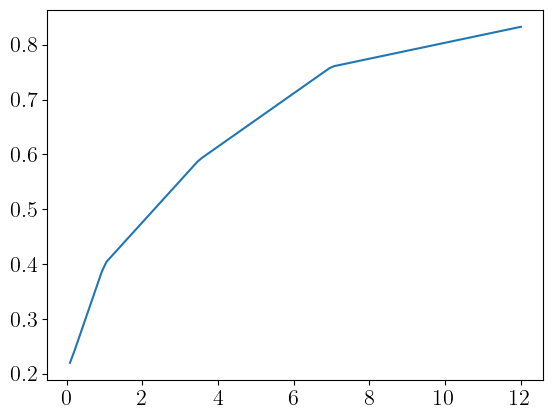

In [4]:
def log_normal(mean_log_a, sigma_log_a, num_samples):
    log_a_samples = np.random.normal(mean_log_a, sigma_log_a, num_samples)
    return log_a_samples

def bimodal_log_normal(mean_log_a1, sigma_log_a1, mean_log_a2, sigma_log_a2, num_samples, weight1=0.5):
    # Determine how many samples to draw from each distribution
    num_samples_1 = int(num_samples * weight1)
    num_samples_2 = num_samples - num_samples_1  # Remaining samples for the second distribution

    # Generate samples from the first log-normal distribution
    log_a_samples_1 = np.random.normal(mean_log_a1, sigma_log_a1, num_samples_1)
    
    # Generate samples from the second log-normal distribution
    log_a_samples_2 = np.random.normal(mean_log_a2, sigma_log_a2, num_samples_2)

    # Combine the two sets of samples
    combined_log_a_samples = np.concatenate([log_a_samples_1, log_a_samples_2])

    return combined_log_a_samples

def generate_powerlaw_data(mean_log_a, sigma_log_a, alpha, lower_value, upper_value, num_samples):
    # Generate uniform random numbers
    
    weight=0.2
    num_samples_gaussian = int(weight*num_samples)
    num_samples_powelaw  = int((1-weight)*num_samples)
    
    log_a_samples = np.random.normal(mean_log_a, sigma_log_a, num_samples_gaussian)

    random_values = np.random.uniform(0,1,num_samples_powelaw)
    
    # Apply the inverse CDF transformation to get power-law distributed samples
    powerlaw_samples = ((upper_value**(alpha+1) - lower_value**(alpha+1)) * random_values + lower_value**(alpha+1))**(1/(alpha+1))
    
    values_a = np.concatenate([log_a_samples, np.log10(powerlaw_samples)])
    
    return values_a

def generate_eccentricities(num_points):

    # Generate uniform random numbers between 0 and 1
    u = np.random.uniform(0, 1, num_points)
    
    # Apply the inverse CDF to get eccentricities
    eccentricities = u**1.2
    
    return eccentricities

def generate_physical_separation(semi_major_axis, eccentricity):

    inclination_deg = np.random.uniform(0,180,1)
    major_axis_angle_deg = np.random.uniform(0,360,1)
    # Convert inclination and major axis angle to radians
    inclination_rad = np.radians(inclination_deg)
    major_axis_angle_rad = np.radians(major_axis_angle_deg)
    
    # Generate random true anomalies (nu) uniformly distributed between 0 and 2*pi
    true_anomaly = np.random.uniform(0, 2 * np.pi, 1)
    
    # Calculate the physical separation r at each true anomaly
    r = semi_major_axis * (1 - eccentricity**2) / (1 + eccentricity * np.cos(true_anomaly))
    
    # Calculate the projected separation, accounting for the inclination and major axis orientation
    r_projected = r * np.sqrt(np.cos(true_anomaly + major_axis_angle_rad)**2 + 
                              np.sin(true_anomaly + major_axis_angle_rad)**2 * np.cos(inclination_rad)**2)
    
    return r_projected

def logsemimajoraxis(mass):
    A = np.zeros(mass.shape[0])

    w = mass<=0.1
    A[w] = 10**log_normal(np.log10(4.5), 0.5, mass[w].shape[0])

    w = (mass>0.1)&(mass<0.7)
    A[w] = 10**log_normal(np.log10(5.3), 1.3, mass[w].shape[0])

    w = (mass>=0.7)&(mass<1.5)
    A[w] = 10**log_normal(np.log10(45), 2.3, mass[w].shape[0])

    w = (mass>=1.5)&(mass<5)
    A[w] = 10**bimodal_log_normal(np.log10(0.1), 0.5, np.log10(350), 1.2, num_samples=mass[w].shape[0], weight1=0.35)

    w = (mass>=5)&(mass<16)
    A[w] = 10**bimodal_log_normal(np.log10(0.1), 0.5, np.log10(350), 1.2, num_samples=mass[w].shape[0], weight1=0.35)

    w = mass>=16
    A[w] = 10**generate_powerlaw_data(np.log10(0.1), 0.4, -1.1, 0.1, 10**5, num_samples=mass[w].shape[0])

    return A

def angular_separation_au_pc(physical_separation_au, distance_pc):
    
    # 1 parsec = 206,265 AU, so convert the distance from pc to AU
    distance_au = distance_pc * 206265
    
    # Calculate angular separation in arcseconds
    theta_arcseconds = (physical_separation_au / distance_au) * 206265
    
    return theta_arcseconds

In [5]:
def create_binaries(mass_ext, distance):

    is_binary     = np.full(mass_ext.shape[0], False)
    ids_companion = np.full(mass_ext.shape[0], -10)
    ids = np.arange(0,mass_ext.shape[0],1)

    # With the multiplicity fraction MF we compute if a star of our population is in a binary system 
    prob_MF = MF_law(mass_ext)
    rando   = np.random.uniform(0,1,mass_ext.shape[0])
    is_binary[rando>=prob_MF] = True

    # Create a pandas df to work with the binarity
    binary_pandas = {'mass':mass_ext, 'is_binary': is_binary,      'ids_companion': ids_companion,
                        'q': np.full(mass_ext.shape[0], -1),                'fail': np.full(mass_ext.shape[0], False),
                'primary': np.full(mass_ext.shape[0], 'xxx'),                  'A': np.full(mass_ext.shape[0], np.NaN),
                        'e': np.full(mass_ext.shape[0], np.nan), 'proj_separation': np.full(mass_ext.shape[0], np.NaN),
                  'ang_sep': np.full(mass_ext.shape[0], np.NaN),        'resolved': np.full(mass_ext.shape[0], 'xxx')}
    binary_pandas = pd.DataFrame(binary_pandas)

    #Section that couple two stars
    control=0
    while control==0:
        w = ((binary_pandas['is_binary'].values == True) &
            (binary_pandas['ids_companion'].values == -10) &
            (binary_pandas['fail'].values == False))
        
        if ids[w].shape[0] < 2:
            if ids[w].shape[0]==1:
                binary_pandas.loc[ids[w][0], 'fail'] = True
            break  # Exit the loop

        id_select = np.random.choice(ids[w])
        ids_binaries = ids[w]
        ids_binaries = ids_binaries[ids_binaries!=id_select]

        qs = np.arange(0,1.05, 0.05)
        random.shuffle(qs)

        # c=-1
        # id_secondary = -10
        # for q in qs:
        #     c=+1
        #     m1 = mass_ext[id_select]
        #     m2_exp = m1*(1/q)

        #     difference = mass_ext[ids_binaries]-m2_exp
        #     ww = ((difference>=-0.1)&(difference<=0))
        #     if difference[ww].shape[0]>0:
        #         id_secondary = ids_binaries[np.argmin(difference[ww])]
        #         break

        id_secondary = -10
        q = np.random.uniform(0,1,1)

        m1 = mass_ext[id_select]
        m2_exp = m1*(1/q)

        difference = mass_ext[ids_binaries]-m2_exp
        ww = ((difference>=-0.1)&(difference<=0))
        if difference[ww].shape[0]>0:
            id_secondary = ids_binaries[np.argmin(difference[ww])]


        if id_secondary == -10:
            binary_pandas.loc[id_select, 'fail'] = True
        else:
            binary_pandas.loc[id_select, 'ids_companion'] = id_secondary
            binary_pandas.loc[id_select, 'primary'] = 'yes'
            binary_pandas.loc[id_select, 'q'] = q

            binary_pandas.loc[id_secondary, 'ids_companion'] = id_select
            binary_pandas.loc[id_secondary, 'primary'] = 'no'
            binary_pandas.loc[id_secondary, 'q'] = q

    w = binary_pandas.primary == 'yes'
    ids_primaries = ids[w]

    masses = binary_pandas.iloc[ids_primaries]['mass'].values
    binary_pandas.loc[ids_primaries, 'A'] = logsemimajoraxis(masses)
    binary_pandas.loc[ids_primaries, 'e'] = generate_eccentricities(masses.shape[0])

    A = binary_pandas.iloc[ids_primaries]['A'].values
    e = binary_pandas.iloc[ids_primaries]['e'].values

    binary_pandas.loc[ids_primaries, 'proj_separation'] = generate_physical_separation(A,e)
   
    proj_separation = binary_pandas.iloc[ids_primaries]['proj_separation'].values

    binary_pandas.loc[ids_primaries, 'ang_sep'] = angular_separation_au_pc(proj_separation, distance)

    w = (binary_pandas.primary == 'yes')&(binary_pandas['ang_sep'].values>0.6)
    ids_resolved = ids[w]
    binary_pandas.loc[ids_resolved, 'resolved'] = 'yes'

    w = (binary_pandas.primary == 'yes')&(binary_pandas['ang_sep'].values<=0.6)
    ids_resolved = ids[w]
    binary_pandas.loc[ids_resolved, 'resolved'] = 'no'
    
    return binary_pandas

In [6]:
logage = 8.5
FeH = 0 
Av = 0 
d = 12
Mcluster = 2000
Nstars = None

file_path = 'PARSEC/ALL/%1.2f_%1.2f.csv' % (FeH, logage)

#-------------- LOAD THE TABLES OF THE NEEDED PARSEC ISOCHRONE -----------------------
DF = pd.read_csv(file_path)

MASSES = DF.Mini.values
Mact   = DF.Mass.values
MG     = DF.G.values
MG_BP  = DF.BP.values
MG_RP  = DF.RP.values
Teff   = DF.logTe.values

Mu     = DF.u.values
Mb     = DF.b.values
Mv     = DF.v.values
Mr     = DF.r.values
Mi     = DF.i.values

#---------------LOAD EXTICTION CURVES-------------------------------

f_ext_G, f_ext_BP, f_ext_RP, f_ext_u, f_ext_b, f_ext_v, f_ext_r, f_ext_i = load_ext_curves(Av)

#---------------LOAD PHOTMOTRIC ERRORS-------------------------------

f_G_err, f_BP_err, f_RP_err, f_b_err, f_v_err, f_r_err, f_i_err = load_photometric_errors()

#----------------CUT THE ISOCRONE TO HAVE ALL STARS BRIGHTER THAN G=20-----------------------------------------------------

w = cut_isochrone(MG, d, Av, f_ext_G, Teff)

MASSES, Mact, MG, MG_BP, MG_RP, Teff = MASSES[w], Mact[w], MG[w], MG_BP[w], MG_RP[w], Teff[w]
Mu, Mb, Mv, Mr, Mi = Mu[w], Mb[w], Mv[w], Mr[w], Mi[w]

#-----------------------------------------------------------------------------------------------------------------------

mass_ext = extract_masses(MASSES, Nstars, Mcluster)
binary_pandas = create_binaries(mass_ext, m_to_d(d))

In [22]:
logage = 8.5
FeH = 0 
Av = 0 
d = 12
Mcluster = 2000
Nstars = None

file_path = 'PARSEC/ALL/%1.2f_%1.2f.csv' % (FeH, logage)

#-------------- LOAD THE TABLES OF THE NEEDED PARSEC ISOCHRONE -----------------------
DF = pd.read_csv(file_path)

MASSES = DF.Mini.values
Mact   = DF.Mass.values
MG     = DF.G.values
MG_BP  = DF.BP.values
MG_RP  = DF.RP.values
Teff   = DF.logTe.values

Mu     = DF.u.values
Mb     = DF.b.values
Mv     = DF.v.values
Mr     = DF.r.values
Mi     = DF.i.values

#---------------LOAD EXTICTION CURVES-------------------------------

f_ext_G, f_ext_BP, f_ext_RP, f_ext_u, f_ext_b, f_ext_v, f_ext_r, f_ext_i = load_ext_curves(Av)

#---------------LOAD PHOTMOTRIC ERRORS-------------------------------

f_G_err, f_BP_err, f_RP_err, f_b_err, f_v_err, f_r_err, f_i_err = load_photometric_errors()

#----------------CUT THE ISOCRONE TO HAVE ALL STARS BRIGHTER THAN G=20-----------------------------------------------------

w = cut_isochrone(MG, d, Av, f_ext_G, Teff)

MASSES, Mact, MG, MG_BP, MG_RP, Teff = MASSES[w], Mact[w], MG[w], MG_BP[w], MG_RP[w], Teff[w]
Mu, Mb, Mv, Mr, Mi = Mu[w], Mb[w], Mv[w], Mr[w], Mi[w]

if MASSES.shape[0]!= 0:
    IMF = IMF_law(MASSES)
    norm_IMF = np.trapz(IMF, x=MASSES)
    IMF = IMF / norm_IMF

    integral = np.zeros(MASSES.shape[0])
    for i in range(1,MASSES.shape[0]+1):
        integral[i-1] = np.trapz(IMF[0:i], x=MASSES[0:i])

    f_IMF = interpolate.interp1d(integral,MASSES, bounds_error=False, fill_value=0)

#-----------------------------------------------------------------------------------------------------------------------

mass_ext = extract_masses(MASSES,Nstars, Mcluster)
binary_pandas = create_binaries(mass_ext, m_to_d(d))
mass_ext = binary_pandas.mass.values

f_G    = interpolate.interp1d(MASSES,MG   , bounds_error=False, fill_value=0)
f_BP   = interpolate.interp1d(MASSES,MG_BP, bounds_error=False, fill_value=0)
f_RP   = interpolate.interp1d(MASSES,MG_RP, bounds_error=False, fill_value=0)
f_Mact = interpolate.interp1d(MASSES,Mact , bounds_error=False, fill_value=0)
f_Teff = interpolate.interp1d(MASSES,Teff , bounds_error=False, fill_value=0)

f_u    = interpolate.interp1d(MASSES,Mu   , bounds_error=False, fill_value=0)
f_b    = interpolate.interp1d(MASSES,Mb   , bounds_error=False, fill_value=0)
f_v    = interpolate.interp1d(MASSES,Mv   , bounds_error=False, fill_value=0)
f_r    = interpolate.interp1d(MASSES,Mr   , bounds_error=False, fill_value=0)
f_i    = interpolate.interp1d(MASSES,Mi   , bounds_error=False, fill_value=0)

Teff_s  = f_Teff(mass_ext) 
Mact_s  = f_Mact(mass_ext)

MG_s    = f_G(mass_ext)    + Av*f_ext_G(10**Teff_s)  + d 
MG_BP_s = f_BP(mass_ext)   + Av*f_ext_BP(10**Teff_s) + d
MG_RP_s = f_RP(mass_ext)   + Av*f_ext_RP(10**Teff_s) + d

# MG_u_s = f_u(mass_ext)   + Av*f_ext_u(10**Teff_s) + d
# MG_b_s = f_b(mass_ext)   + Av*f_ext_b(10**Teff_s) + d
# MG_v_s = f_v(mass_ext)   + Av*f_ext_v(10**Teff_s) + d
# MG_r_s = f_r(mass_ext)   + Av*f_ext_r(10**Teff_s) + d
# MG_i_s = f_i(mass_ext)   + Av*f_ext_i(10**Teff_s) + d

# Zeropoints in the Vegamag system (see documentation table 5.2)
# These are for Gaia DR3!
G_ZP  = 25.6874
BP_ZP = 25.3385
RP_ZP = 24.7479

def mag_to_flux(magnitudes, band):
    if band == 'G':  ZP = 25.6874  #G
    if band == 'BP': ZP = 25.3385 #BP
    if band == 'RP': ZP = 24.7479 #RP
    return 10 ** ((ZP - magnitudes) / 2.5)

def flux_to_mag(fluxes, band):
    if band == 'G':  ZP = 25.6874  #G
    if band == 'BP': ZP = 25.3385 #BP
    if band == 'RP': ZP = 24.7479 #RP
    return -2.5 * np.log10(fluxes) + ZP

MG_s_combined  = np.copy(MG_s)
MBP_s_combined = np.copy(MG_BP_s)
MRP_s_combined = np.copy(MG_RP_s)

ids = np.arange(0, mass_ext.shape[0], 1)
for nnn in ids[(binary_pandas.primary.values == 'yes')&(binary_pandas.resolved.values == 'no')]:

    flux_G_primary, flux_BP_primary, flux_RP_primary = mag_to_flux(MG_s[nnn], 'G'), mag_to_flux(MG_BP_s[nnn], 'BP'), mag_to_flux(MG_RP_s[nnn], 'RP')
    id_secondary = binary_pandas.ids_companion.values[nnn]
    flux_G_secondary, flux_BP_secondary, flux_RP_secondary = mag_to_flux(MG_s[id_secondary], 'G'), mag_to_flux(MG_BP_s[id_secondary], 'BP'), mag_to_flux(MG_RP_s[id_secondary], 'RP')

    MG_s_combined[nnn]  = flux_to_mag( flux_G_primary + flux_G_secondary  , 'G' )
    MBP_s_combined[nnn] = flux_to_mag( flux_BP_primary + flux_BP_secondary, 'BP')
    MRP_s_combined[nnn] = flux_to_mag( flux_RP_primary + flux_RP_secondary, 'RP')

    MG_s_combined[id_secondary]  = np.nan
    MBP_s_combined[id_secondary] = np.nan
    MRP_s_combined[id_secondary] = np.nan

MG_s    += np.random.normal(0,  f_G_err(MG_s_combined))
MG_BP_s += np.random.normal(0,  f_BP_err(MBP_s_combined))
MG_RP_s += np.random.normal(0,  f_RP_err(MRP_s_combined))

In [3]:
plt.scatter(MG_BP_s - MG_RP_s, MG_s, s=10)
plt.gca().invert_yaxis()

NameError: name 'MG_BP_s' is not defined

In [14]:
binary_pandas.primary.values == 'yes'

array([False, False, False, ..., False,  True,  True])

,mass,is_binary,ids_companion,q,fail,primary,A,e,proj_separation,ang_sep,resolved
134,0.928525,True,84,0.409738,False,yes,0.104427,0.820996,0.055479,0.000022,no
160,0.705924,True,76,0.403742,False,yes,1.962709,0.795449,1.151209,0.000458,no
168,0.742803,True,199,0.542491,False,yes,202.016522,0.929967,48.770729,0.019416,no
176,1.035207,True,46,0.981962,False,yes,87.128417,0.241188,91.251920,0.036328,no
182,0.817863,True,341,0.955327,False,yes,16.483803,0.023203,16.365523,0.006515,no
...,...,...,...,...,...,...,...,...,...,...,...
1683,1.080788,True,483,0.572108,False,yes,0.022427,0.755119,0.014921,0.000006,no
1687,0.767794,True,669,0.933817,False,yes,0.577802,0.160665,0.599487,0.000239,no
1688,0.707695,True,577,0.999493,False,yes,1.126079,0.618457,0.974771,0.000388,no
1693,0.675470,True,514,0.684884,False,yes,5.005587,0.032737,4.990308,0.001987,no


In [467]:
binary_pandas[binary_pandas.resolved == 'yes']

,mass,is_binary,ids_companion,q,fail,primary,A,e,proj_separation,ang_sep,resolved
278,0.758185,True,82,0.565353,False,yes,396452.603012,0.546013,371476.067131,147.887286,yes
314,1.108120,True,217,0.434478,False,yes,236924.764108,0.139240,244686.634509,97.411504,yes
347,0.850138,True,468,0.963978,False,yes,18335.338007,0.058230,18468.476377,7.352433,yes
469,0.844370,True,167,0.552344,False,yes,2454.654698,0.547447,2297.039150,0.914468,yes
478,1.399744,True,63,0.581250,False,yes,21535.060251,0.464156,21403.077734,8.520719,yes
...,...,...,...,...,...,...,...,...,...,...,...
1664,0.744121,True,533,0.941195,False,yes,44757.940614,0.278631,46869.091756,18.658922,yes
1666,1.024499,True,904,0.856701,False,yes,23250.396325,0.198459,24268.243581,9.661362,yes
1672,1.204779,True,784,0.976857,False,yes,58962.165087,0.030623,58729.012568,23.380441,yes
1677,0.728318,True,1080,0.473102,False,yes,31874.830856,0.082281,32385.331545,12.892833,yes


In [26]:
def create_binaries(mass_ext):

    is_binary     = np.full(mass_ext.shape[0], False)
    ids_companion = np.full(mass_ext.shape[0], -10)
    ids = np.arange(0,mass_ext.shape[0],1)

    # With the multiplicity fraction MF we compute if a star of our population is in a binary system 
    prob_MF = MF_law(mass_ext)
    rando   = np.random.uniform(0,1,mass_ext.shape[0])
    is_binary[rando>=prob_MF] = True

    # Create a pandas df to work with the binarity
    binary_pandas = {'mass':mass_ext, 'is_binary': is_binary,      'ids_companion': ids_companion,
                        'q': np.full(mass_ext.shape[0], -1),                'fail': np.full(mass_ext.shape[0], False),
                'primary': np.full(mass_ext.shape[0], 'xxx'),                'A': np.full(mass_ext.shape[0], np.NaN),
                        'e': np.full(mass_ext.shape[0], np.nan), 'proj_separation': np.full(mass_ext.shape[0], np.NaN)}
    binary_pandas = pd.DataFrame(binary_pandas)
    binary_pandas = binary_pandas.sort_values('mass')

    #Section that couple two stars
    control=0
    while control==0:
        w = ((binary_pandas['is_binary'].values == True) &
            (binary_pandas['ids_companion'].values == -10) &
            (binary_pandas['fail'].values == False))
        
        if ids[w].shape[0] < 2:
            if ids[w].shape[0]==1:
                binary_pandas.loc[ids[w][0], 'fail'] = True
            break  # Exit the loop

        id_select = np.random.choice(ids[w])
        ids_binaries = ids[w]
        ids_binaries = ids_binaries[ids_binaries!=id_select]

        qs = np.arange(0,1.05, 0.05)
        random.shuffle(qs)

        id_secondary = -10
        q = np.random.uniform(0,1,1)

        m1 = mass_ext[id_select]
        m2_exp = m1*(1/q)

        difference = mass_ext[ids_binaries]-m2_exp
        ww = ((difference>=-0.1)&(difference<=0))
        if difference[ww].shape[0]>0:
            id_secondary = ids_binaries[np.argmin(difference[ww])]


        if id_secondary == -10:
            binary_pandas.loc[id_select, 'fail'] = True
        else:
            binary_pandas.loc[id_select, 'ids_companion'] = id_secondary
            binary_pandas.loc[id_select, 'primary'] = 'yes'
            binary_pandas.loc[id_select, 'q'] = q

            binary_pandas.loc[id_secondary, 'ids_companion'] = id_select
            binary_pandas.loc[id_secondary, 'primary'] = 'no'
            binary_pandas.loc[id_secondary, 'q'] = q

    w = binary_pandas.primary == 'yes'
    ids_primaries = ids[w]

    masses = binary_pandas.iloc[ids_primaries]['mass'].values
    binary_pandas.loc[ids_primaries, 'A'] = np.int32(logsemimajoraxis(masses))
    binary_pandas.loc[ids_primaries, 'e'] = generate_eccentricities(masses.shape[0])

    A = binary_pandas.iloc[ids_primaries]['A'].values
    e = binary_pandas.iloc[ids_primaries]['e'].values

    binary_pandas.loc[ids_primaries, 'proj_separation'] = generate_physical_separation(A,e).round(2)

    return binary_pandas

In [102]:
import numpy as np
import matplotlib.pyplot as plt

def log_normal(mean_log_a, sigma_log_a, num_samples):
    log_a_samples = np.random.normal(mean_log_a, sigma_log_a, num_samples)
    return log_a_samples

def bimodal_log_normal(mean_log_a1, sigma_log_a1, mean_log_a2, sigma_log_a2, num_samples, weight1=0.5):
    # Determine how many samples to draw from each distribution
    num_samples_1 = int(num_samples * weight1)
    num_samples_2 = num_samples - num_samples_1  # Remaining samples for the second distribution

    # Generate samples from the first log-normal distribution
    log_a_samples_1 = np.random.normal(mean_log_a1, sigma_log_a1, num_samples_1)
    
    # Generate samples from the second log-normal distribution
    log_a_samples_2 = np.random.normal(mean_log_a2, sigma_log_a2, num_samples_2)

    # Combine the two sets of samples
    combined_log_a_samples = np.concatenate([log_a_samples_1, log_a_samples_2])

    return combined_log_a_samples

def generate_powerlaw_data(mean_log_a, sigma_log_a, alpha, lower_value, upper_value, num_samples):
    # Generate uniform random numbers
    
    weight=0.2
    num_samples_gaussian = int(weight*num_samples)
    num_samples_powelaw  = int((1-weight)*num_samples)
    
    log_a_samples = np.random.normal(mean_log_a, sigma_log_a, num_samples_gaussian)

    random_values = np.random.uniform(0,1,num_samples_powelaw)
    
    # Apply the inverse CDF transformation to get power-law distributed samples
    powerlaw_samples = ((upper_value**(alpha+1) - lower_value**(alpha+1)) * random_values + lower_value**(alpha+1))**(1/(alpha+1))
    
    values_a = np.concatenate([log_a_samples, np.log10(powerlaw_samples)])
    
    return values_a

def generate_eccentricities(num_points):


    # Generate uniform random numbers between 0 and 1
    u = np.random.uniform(0, 1, num_points)
    
    # Apply the inverse CDF to get eccentricities
    eccentricities = u**1.2
    
    return eccentricities

def generate_physical_separation(semi_major_axis, eccentricity):

    inclination_deg = np.random.uniform(0,180,1)
    major_axis_angle_deg = np.random.uniform(0,360,1)
    # Convert inclination and major axis angle to radians
    inclination_rad = np.radians(inclination_deg)
    major_axis_angle_rad = np.radians(major_axis_angle_deg)
    
    # Generate random true anomalies (nu) uniformly distributed between 0 and 2*pi
    true_anomaly = np.random.uniform(0, 2 * np.pi, 1)
    
    # Calculate the physical separation r at each true anomaly
    r = semi_major_axis * (1 - eccentricity**2) / (1 + eccentricity * np.cos(true_anomaly))
    
    # Calculate the projected separation, accounting for the inclination and major axis orientation
    r_projected = r * np.sqrt(np.cos(true_anomaly + major_axis_angle_rad)**2 + 
                              np.sin(true_anomaly + major_axis_angle_rad)**2 * np.cos(inclination_rad)**2)
    
    return r_projected

def logsemimajoraxis(mass):
    A = np.zeros(mass.shape[0])

    w = mass<=0.1
    A[w] = 10**log_normal(np.log10(4.5), 0.5, mass[w].shape[0])

    w = (mass>0.1)&(mass<0.7)
    A[w] = 10**log_normal(np.log10(5.3), 1.3, mass[w].shape[0])

    w = (mass>=0.7)&(mass<1.5)
    A[w] = 10**log_normal(np.log10(45), 2.3, mass[w].shape[0])

    w = (mass>=1.5)&(mass<5)
    A[w] = 10**bimodal_log_normal(np.log10(0.1), 0.5, np.log10(350), 1.2, num_samples=mass[w].shape[0], weight1=0.35)

    w = (mass>=1.5)&(mass<5)
    A[w] = 10**bimodal_log_normal(np.log10(0.1), 0.5, np.log10(350), 1.2, num_samples=mass[w].shape[0], weight1=0.35)

    w = (mass>=5)&(mass<16)
    A[w] = 10**bimodal_log_normal(np.log10(0.1), 0.5, np.log10(350), 1.2, num_samples=mass[w].shape[0], weight1=0.35)

    w = mass>=16
    A[w] = 10**generate_powerlaw_data(np.log10(0.1), 0.4, -1.1, 0.1, 10**5, num_samples=mass[w].shape[0])

    return A

In [101]:
is_binary     = np.full(mass_ext.shape[0], False)
ids_companion = np.full(mass_ext.shape[0], -10)
ids = np.arange(0,mass_ext.shape[0],1)

# With the multiplicity fraction MF we compute if a star of our population is in a binary system 
prob_MF = MF_law(mass_ext)
rando   = np.random.uniform(0,1,mass_ext.shape[0])
is_binary[rando>=prob_MF] = True

# With the CSF function we compute how many stars are companion of another
n_companions = np.array([ np.random.poisson(1+CSF_law(m)) for m in mass_ext ])
n_companions[~is_binary] = 0
n_companions[n_companions>2] = 2
n_companions[(is_binary==True)&(n_companions==0)] = 1

# Create a pandas df to work with the binarity
binary_pandas = {
    'mass': mass_ext,
    'is_binary': is_binary,
    'ids_companion': np.full(mass_ext.shape[0], [-10], dtype=object),
    'n_companion': n_companions,
    'q': np.full(mass_ext.shape[0], np.nan, dtype=object),  # Set dtype to object
    'fail': np.full(mass_ext.shape[0], False),
    'primary': np.full(mass_ext.shape[0], 'xxx'),
    'secondary': np.full(mass_ext.shape[0], 'xxx'),
    'A': np.full(mass_ext.shape[0], np.NaN),
    'e': np.full(mass_ext.shape[0], np.nan),
    'proj_separation': np.full(mass_ext.shape[0], np.NaN)
}

binary_pandas = pd.DataFrame(binary_pandas)

binary_pandas = match_binaries(binary_pandas, mass_ext, ids)

binary_pandas

,mass,is_binary,ids_companion,n_companion,q,fail,primary,secondary,A,e,proj_separation
0,0.614872,True,694,1,0.286744,False,no,yes,NaN,NaN,NaN
1,1.477633,True,-10,2,NaN,True,xxx,xxx,NaN,NaN,NaN
2,1.069285,True,"[921, 663]",2,0.65547,False,yes,no,NaN,NaN,NaN
3,0.857561,False,-10,0,NaN,False,xxx,xxx,NaN,NaN,NaN
4,1.011340,True,-10,2,NaN,True,xxx,xxx,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1710,0.647781,False,-10,0,NaN,False,xxx,xxx,NaN,NaN,NaN
1711,2.255727,False,-10,0,NaN,False,xxx,xxx,NaN,NaN,NaN
1712,1.011244,True,839,1,0.771212,False,yes,no,NaN,NaN,NaN
1713,0.607922,True,"[1368, 1071]",2,0.842413,False,no,yes,NaN,NaN,NaN


12

In [105]:
distance = m_to_d(d)

In [106]:
w = (binary_pandas.primary == 'yes')&(binary_pandas.n_companion == 1)
ids_primaries = ids[w]

masses = binary_pandas.iloc[ids_primaries]['mass'].values
binary_pandas.loc[ids_primaries, 'A'] = logsemimajoraxis(masses)
binary_pandas.loc[ids_primaries, 'e'] = generate_eccentricities(masses.shape[0])

A = binary_pandas.iloc[ids_primaries]['A'].values
e = binary_pandas.iloc[ids_primaries]['e'].values

binary_pandas.loc[ids_primaries, 'proj_separation'] = generate_physical_separation(A,e)

proj_separation = binary_pandas.iloc[ids_primaries]['proj_separation'].values

binary_pandas.loc[ids_primaries, 'ang_sep'] = angular_separation_au_pc(proj_separation, distance)

w = (binary_pandas.primary == 'yes')&(binary_pandas['ang_sep'].values>0.6)
ids_resolved = ids[w]
binary_pandas.loc[ids_resolved, 'resolved'] = 'yes'

w = (binary_pandas.primary == 'yes')&(binary_pandas['ang_sep'].values<=0.6)
ids_resolved = ids[w]
binary_pandas.loc[ids_resolved, 'resolved'] = 'no'

In [108]:
binary_pandas

,mass,is_binary,ids_companion,n_companion,q,fail,primary,secondary,A,e,proj_separation,ang_sep,resolved
0,0.614872,True,694,1,0.286744,False,no,yes,NaN,NaN,NaN,NaN,NaN
1,1.477633,True,-10,2,NaN,True,xxx,xxx,NaN,NaN,NaN,NaN,NaN
2,1.069285,True,"[921, 663]",2,0.65547,False,yes,no,NaN,NaN,NaN,NaN,NaN
3,0.857561,False,-10,0,NaN,False,xxx,xxx,NaN,NaN,NaN,NaN,NaN
4,1.011340,True,-10,2,NaN,True,xxx,xxx,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1710,0.647781,False,-10,0,NaN,False,xxx,xxx,NaN,NaN,NaN,NaN,NaN
1711,2.255727,False,-10,0,NaN,False,xxx,xxx,NaN,NaN,NaN,NaN,NaN
1712,1.011244,True,839,1,0.771212,False,yes,no,0.000029,0.726444,0.000015,6.117982e-09,no
1713,0.607922,True,"[1368, 1071]",2,0.842413,False,no,yes,NaN,NaN,NaN,NaN,NaN


In [ ]:
pdf

In [107]:
np.log10(4.5)

0.6532125137753437

In [562]:
binary_pandas.iloc[165]

mass             0.893885
is_binary            True
ids_companion        3299
Name: 165, dtype: object

In [165]:
file_path = 'PARSEC/ALL/%1.2f_%1.2f.csv' % (0.00, 8.50)
DF = pd.read_csv(file_path)
DF

,Unnamed: 0,MH,logAge,Mini,Mass,logL,logTe,logg,G,BP,RP,u,b,v,r,i
0,48996,0.0,8.50004,0.090000,0.090,-3.138,3.3837,5.017,14.304,16.849,12.883,21.042,18.583,16.590,14.814,12.621
1,48997,0.0,8.50004,0.092152,0.092,-3.116,3.3874,5.021,14.250,16.797,12.830,20.997,18.532,16.538,14.761,12.567
2,48998,0.0,8.50004,0.100000,0.100,-3.038,3.4009,5.031,14.053,16.603,12.633,20.823,18.342,16.345,14.564,12.370
3,48999,0.0,8.50004,0.102524,0.103,-3.015,3.4045,5.034,13.997,16.548,12.577,20.774,18.288,16.290,14.509,12.313
4,49000,0.0,8.50004,0.113816,0.114,-2.914,3.4204,5.042,13.693,16.166,12.285,20.284,17.879,15.908,14.169,12.016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,49222,0.0,8.50004,3.418512,3.417,4.002,3.5228,0.013,-3.629,-1.613,-4.925,1.125,-0.333,-1.834,-3.417,-5.201
227,49223,0.0,8.50004,3.418517,3.417,4.015,3.5211,-0.007,-3.612,-1.541,-4.920,1.129,-0.274,-1.758,-3.379,-5.194
228,49224,0.0,8.50004,3.418529,3.417,4.046,3.5170,-0.054,-3.572,-1.370,-4.907,1.138,-0.131,-1.578,-3.290,-5.176
229,49225,0.0,8.50004,3.418540,3.417,4.065,3.5144,-0.084,-3.545,-1.258,-4.897,1.146,-0.038,-1.461,-3.231,-5.163


In [134]:
def isochrone(logage, FeH, Av, d):


   #---Check if logage and FeH are within the specified limits----------------------------------------------------
    logage_limits = [6.5,10.12]
    FeH_limits    = [-1.0,0.8]

    if not (logage_limits[0] <= logage <= logage_limits[1]):
        return f"Error: logage value {logage} is out of bounds. It should be between {logage_limits[0]} and {logage_limits[1]}."

    if not (FeH_limits[0] <= FeH <= FeH_limits[1]):
        return f"Error: FeH value {FeH} is out of bounds. It should be between {FeH_limits[0]} and {FeH_limits[1]}."

    # Proceed with loading the CSV file if values are within limits
    file_path = 'PARSEC/ALL/%1.2f_%1.2f.csv' % (FeH, logage)

    try:
        DF = pd.read_csv(file_path)
    except FileNotFoundError:
        return f"Error: File '{file_path}' not found."

    

    MASSES = DF.Mini.values
    Mact   = DF.Mass.values
    MG     = DF.G.values
    MG_BP  = DF.BP.values
    MG_RP  = DF.RP.values
    Teff   = DF.logTe.values

    Mu     = DF.u.values
    Mb     = DF.b.values
    Mv     = DF.v.values
    Mr     = DF.r.values
    Mi     = DF.i.values
    
    #---------------LOAD EXTICTION CURVES-------------------------------

    f_ext_G, f_ext_BP, f_ext_RP, f_ext_u, f_ext_b, f_ext_v, f_ext_r, f_ext_i = load_ext_curves(Av)

    #----------------CUT THE ISOCRONE TO HAVE ALL STARS BRIGHTER THAN G=20-----------------------------------------------------

    w = cut_isochrone(MG, d, Av, f_ext_G, Teff)

    MASSES, Mact, MG, MG_BP, MG_RP, Teff = MASSES[w], Mact[w], MG[w], MG_BP[w], MG_RP[w], Teff[w]
    Mu, Mb, Mv, Mr, Mi = Mu[w], Mb[w], Mv[w], Mr[w], Mi[w]

    #-----------------------------------------------------------------------------------------------------------------------
        
    mass_ext = MASSES

    f_G    = interpolate.interp1d(MASSES,MG   , bounds_error=False, fill_value=0)
    f_BP   = interpolate.interp1d(MASSES,MG_BP, bounds_error=False, fill_value=0)
    f_RP   = interpolate.interp1d(MASSES,MG_RP, bounds_error=False, fill_value=0)
    f_Mact = interpolate.interp1d(MASSES,Mact , bounds_error=False, fill_value=0)
    f_Teff = interpolate.interp1d(MASSES,Teff , bounds_error=False, fill_value=0)

    f_u    = interpolate.interp1d(MASSES,Mu   , bounds_error=False, fill_value=0)
    f_b    = interpolate.interp1d(MASSES,Mb   , bounds_error=False, fill_value=0)
    f_v    = interpolate.interp1d(MASSES,Mv   , bounds_error=False, fill_value=0)
    f_r    = interpolate.interp1d(MASSES,Mr   , bounds_error=False, fill_value=0)
    f_i    = interpolate.interp1d(MASSES,Mi   , bounds_error=False, fill_value=0)

    Teff_s  = f_Teff(mass_ext) 
    Mact_s  = f_Mact(mass_ext)

    MG_s    = f_G(mass_ext)    + Av*f_ext_G(10**Teff_s)  + d 
    MG_BP_s = f_BP(mass_ext)   + Av*f_ext_BP(10**Teff_s) + d
    MG_RP_s = f_RP(mass_ext)   + Av*f_ext_RP(10**Teff_s) + d
    
    MG_u_s = f_u(mass_ext)   + Av*f_ext_u(10**Teff_s) + d
    MG_b_s = f_b(mass_ext)   + Av*f_ext_b(10**Teff_s) + d
    MG_v_s = f_v(mass_ext)   + Av*f_ext_v(10**Teff_s) + d
    MG_r_s = f_r(mass_ext)   + Av*f_ext_r(10**Teff_s) + d
    MG_i_s = f_i(mass_ext)   + Av*f_ext_i(10**Teff_s) + d

    #----------------------ADD PHOTOMETRIC ERRORS-----------------------------------------------------------------------------
    BPRP_s = MG_BP_s - MG_RP_s
    Mini_s = mass_ext

    www = MG_s >= 17.6
    MG_u_s[www] = np.nan
    MG_b_s[www] = np.nan
    MG_v_s[www] = np.nan
    MG_r_s[www] = np.nan
    MG_i_s[www] = np.nan
    
    df = {'Mini': Mini_s.round(6), 'Mact': Mact_s.round(3), 'G': MG_s.round(3), 'BP': MG_BP_s.round(3), 'RP': MG_RP_s.round(3), 'BPRP': BPRP_s.round(3), 'u' : MG_u_s.round(3), 'b' : MG_b_s.round(3), 'v' : MG_v_s.round(3), 'r' : MG_r_s.round(3), 'i' : MG_i_s.round(3)}
    CMD= pd.DataFrame(df)
    return CMD

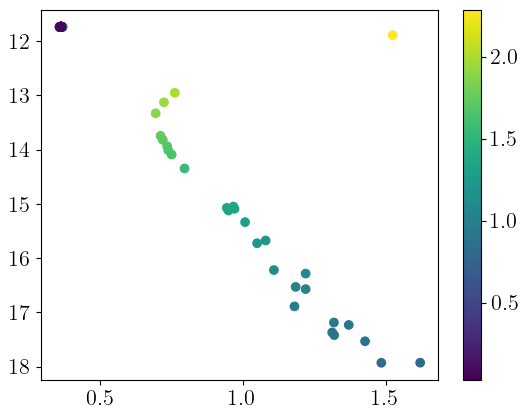

In [98]:
CMD = synthetic_cluster(logage=9, FeH=0, Av=1, d=11, Mcluster=100,save=False)

plt.scatter(CMD.BP-CMD.RP,CMD.G, c=CMD.Mini)
plt.gca().invert_yaxis()
plt.colorbar()

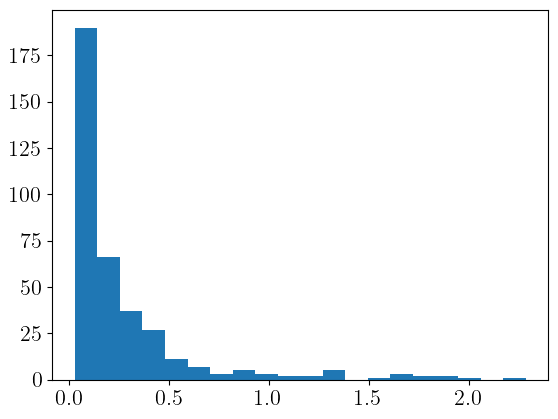

In [99]:
_ = plt.hist(CMD.Mini, bins=20)

In [16]:
import imf

IMF = imf.Kroupa

selected_imf = IMF(mmin=0.03, mmax=40)
masses = imf.make_cluster(100, massfunc=selected_imf, silent=True)

In [17]:
masses.sum()

100.72853073778275

In [7]:
def parallel(k):
    np.random.seed((os.getpid() * int(time.time())) % 123456789)
    nClusters = 10000

    grid_logage = np.arange( 6.8,10.12, 0.01)
    
    grid_FeH    = np.arange(-0.8,  0.6,  0.01).round(2)

    logage   = np.random.choice(grid_logage, nClusters, replace=True)
    FeH      = np.random.choice(   grid_FeH, nClusters, replace=True)

    Nstars   = np.int32(10**np.random.uniform(np.log10(30), np.log10(2000), nClusters))
    
    Av       = np.random.uniform(   0,    5, nClusters).round(2)
    dMod     = np.random.uniform(   4,   15, nClusters)
    
    for i in tqdm(range(nClusters)):
        _ = synthetic_cluster(logage[i], FeH[i], Av[i], dMod[i], Nstars=Nstars[i], save=True, gen_name='Gen3')

In [7]:
import time
import os
import multiprocessing as mp
from functools import partial
#import warnings
#warnings.filterwarnings('ignore')

run=1

if run == 1:
        
    pool = mp.Pool(15)

    results = pool.map(parallel, [k for k in range(0,15)] )
    pool.close()
else:
    print ("---------------NO RUN---------------") 

#warnings.filterwarnings('default')

100%|██████████| 10000/10000 [04:32<00:00, 36.72it/s]


# SCALE THE CMDs

Select randomly 2000 synthetic clusters fit a scaler and use it to scale all the others.
For fist iteration we use CMD (bprp vs g) and (bi vs v)
The scaling works like a substruction of the dMod...

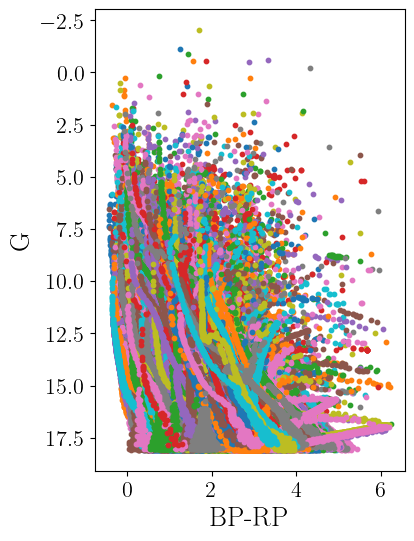

In [8]:
from glob import glob

files = glob('SYNTHETIC_CMDs/Gen3/*.csv')

selected = np.random.choice(files, 2000)

plt.figure(figsize=(4,6))

conta = -1
for paths in selected:
    conta += 1
    CMD = pd.read_csv(paths)
    if conta==0: CMD_all = CMD
    if conta!=0: CMD_all = pd.concat([CMD_all,CMD], ignore_index=True)
    plt.scatter(CMD.BP.values-CMD.RP.values, CMD.G.values, s=10)
    plt.xlabel('BP-RP')
    plt.ylabel('G')

plt.gca().invert_yaxis()

In [9]:
data = {'g'    :  CMD_all.G.values,
        'bprp' :  CMD_all.BP.values - CMD_all.RP.values,
        'v'    :  CMD_all.v.values, 
        'bi'   :  CMD_all.b.values - CMD_all.i.values}

data = pd.DataFrame(data)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(data)

StandardScaler()

In [10]:
def scale_cmds(k):
    file = files[k]
    CMD_original  = pd.read_csv(file)

    data = {'g'    :  CMD_original.G.values,
            'bprp' :  CMD_original.BP.values - CMD_original.RP.values,
            'v'    :  CMD_original.v.values, 
            'bi'   :  CMD_original.b.values - CMD_original.i.values}
    data = pd.DataFrame(data)
    
    data_std = scaler.transform(data)

    CMD_scaled = {'g'    : data_std[:,0],
                  'bprp' : data_std[:,1],
                  'v'    : data_std[:,2],
                  'bi'   : data_std[:,3] }
    CMD_scaled = pd.DataFrame(CMD_scaled)

    CMD_scaled.to_csv('SYNTHETIC_CMDs/Gen3/SCALED/' + file.split('/')[-1])

import multiprocessing as mp

pool = mp.Pool(15)
pool.map(scale_cmds, [k for k in range(0,len(files))] )
pool.close()

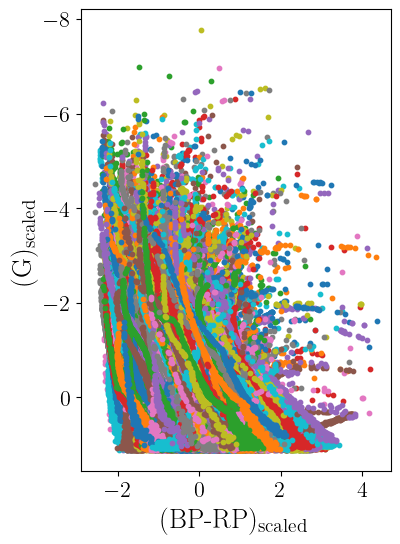

In [11]:
from glob import glob
files = glob('SYNTHETIC_CMDs/Gen3/SCALED/*')

selected = np.random.choice(files, 1000)

plt.figure(figsize=(4,6))

conta = -1
for paths in selected:
    conta += 1
    CMD = pd.read_csv(paths)
    plt.scatter(CMD.bprp, CMD.g, s=10)
    plt.xlabel('(BP-RP)$_{\\rm scaled}$')
    plt.ylabel('(G)$_{\\rm scaled}$')
plt.gca().invert_yaxis()

# CREATE THE TARGETS FILE

Here the targets file is created. 

We cut the generated population of OCs imposing that in (b-i)vs(i) should contain >= 10 stars

In [8]:
from glob import glob
files = glob('SYNTHETIC_CMDs/Gen2/*.csv')

logAge = np.zeros(len(files))
FeH    = np.zeros(len(files))
Av     = np.zeros(len(files))
dMod   = np.zeros(len(files))
plx    = np.zeros(len(files))
NstarsG= np.zeros(len(files))
NstarsS= np.zeros(len(files))

name   = []

for k in range(len(files)):
    logAge[k] = float(files[k].split('/')[-1].split('_')[0])
    FeH[k]    = float(files[k].split('/')[-1].split('_')[1])
    Av[k]     = float(files[k].split('/')[-1].split('_')[2])
    dMod[k]   = float(files[k].split('/')[-1].split('_')[3])
    NstarsG[k] = int(files[k].split('/')[-1].split('_')[4].split('.')[0])
    NstarsS[k] = int(files[k].split('/')[-1].split('_')[5].split('.')[0])
    
    name.append(files[k].split('/')[-1])

plx = 1/(m_to_d(dMod)/1000)

df = {'logAge' : logAge, 'FeH' : FeH, 'Av' : Av, 'dMod' :  dMod, 'plx': plx.round(3), 'Nstars_Gaia' : np.int32(NstarsG), 'Nstars_Synt' : np.int32(NstarsS), 'file' : name}
df = pd.DataFrame(df)

w = df.Nstars_Synt.values>=10
df = df[w]

df = df.sort_values('logAge', ignore_index=True)
df.to_csv('SYNTHETIC_CMDs/gen2.csv')
df.to_csv('FILES/Gen2_targets.csv')

files = df.file.values

df

,logAge,FeH,Av,dMod,plx,Nstars_Gaia,Nstars_Synt,file
0,6.80,0.1,4.46,6.46,5.105,1435,568,6.80_0.1_4.46_6.46_1435_568.csv
1,6.80,0.4,3.98,7.74,2.831,616,192,6.80_0.4_3.98_7.74_616_192.csv
2,6.80,0.6,4.76,4.84,10.765,132,67,6.80_0.6_4.76_4.84_132_67.csv
3,6.80,-0.7,2.25,12.22,0.360,1126,596,6.80_-0.7_2.25_12.22_1126_596.csv
4,6.80,-0.3,0.91,4.32,13.677,56,56,6.80_-0.3_0.91_4.32_56_56.csv
...,...,...,...,...,...,...,...,...
246669,10.11,0.1,0.44,5.72,7.178,144,71,10.11_0.1_0.44_5.72_144_71.csv
246670,10.11,-0.6,1.27,5.91,6.577,168,106,10.11_-0.6_1.27_5.91_168_106.csv
246671,10.11,-0.6,1.91,10.93,0.652,84,20,10.11_-0.6_1.91_10.93_84_20.csv
246672,10.11,0.1,4.13,8.39,2.099,1752,701,10.11_0.1_4.13_8.39_1752_701.csv


# COMPUTE THE QUADTREES
#### ~ 50 minutes

Keeping only lv3 of the QuadTree


In [9]:
class Points():
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Node_X():
    def __init__(self, points, px):
        self.points = points
        self.children, self.t = find_children_x(self, px)

class Node_Y():
    def __init__(self, points, py):
        self.points = points
        self.children, self.t = find_children_y(self, py)

def find_children_x(node, px):
    Xt = np.percentile(node.points.x,px)
    f1 = (node.points.x > Xt)
    f2 = (node.points.x <= Xt)
    C1x, C1y = node.points.x[f1], node.points.y[f1]
    C2x, C2y = node.points.x[f2], node.points.y[f2]
    return [Points(C1x, C1y), Points(C2x, C2y)], Xt

def find_children_y(node, py):
    Yt = np.percentile(node.points.y,py)
    f1 = (node.points.y > Yt)
    f2 = (node.points.y <= Yt)
    C1x, C1y = node.points.x[f1], node.points.y[f1]
    C2x, C2y = node.points.x[f2], node.points.y[f2]
    return [Points(C1x, C1y), Points(C2x, C2y)], Yt

def QuadTree_(p, k, px, py):
    all_sX = []
    all_min_range_sX = []
    all_max_range_sX = []
    all_sY = []
    all_min_range_sY = []
    all_max_range_sY = []
    number_nodes_gen = []
    new_nodes_y = [p]

    for i in range(k):
        new_nodes_x = []
        sX = []
        min_range_sX = []
        max_range_sX = []
        for cil in new_nodes_y:
            sX.append(Node_X(cil, px).t)
            min_range_sX.append(Node_X(cil, px).points.y.min())
            max_range_sX.append(Node_X(cil, px).points.y.max())
            new_nodes_x.append(Node_X(cil, px).children[0])
            new_nodes_x.append(Node_X(cil, px).children[1])
        number_nodes_gen.append(len(new_nodes_x))

        new_nodes_y = []
        sY = []
        min_range_sY = []
        max_range_sY = []
        for cil in new_nodes_x:
            sY.append(Node_Y(cil, py).t)
            min_range_sY.append(Node_Y(cil, py).points.x.min())
            max_range_sY.append(Node_Y(cil, py).points.x.max())
            new_nodes_y.append(Node_Y(cil, py).children[0])
            new_nodes_y.append(Node_Y(cil, py).children[1])

        all_sX.append(sX)
        all_sY.append(sY)
        all_min_range_sX.append(min_range_sX)
        all_max_range_sX.append(max_range_sX)
        all_min_range_sY.append(min_range_sY)
        all_max_range_sY.append(max_range_sY)
        number_nodes_gen.append(len(new_nodes_y))

    all_sY = np.concatenate(all_sY).ravel()
    all_sX = np.concatenate(all_sX).ravel()
    all_min_range_sX = np.concatenate(all_min_range_sX).ravel()
    all_max_range_sX = np.concatenate(all_max_range_sX).ravel()
    all_min_range_sY = np.concatenate(all_min_range_sY).ravel()
    all_max_range_sY = np.concatenate(all_max_range_sY).ravel()
    
    return all_sX, all_sY, all_min_range_sX, all_max_range_sX, all_min_range_sY, all_max_range_sY

def QuadTree(p, k, px, py):
    all_sX = []
    all_sY = []
    number_nodes_gen = []
    new_nodes_y = [p]

    for i in range(k):
        new_nodes_x = []
        sX = []
        for cil in new_nodes_y:
            sX.append(Node_X(cil, px).t)
            new_nodes_x.append(Node_X(cil, px).children[0])
            new_nodes_x.append(Node_X(cil, px).children[1])
        number_nodes_gen.append(len(new_nodes_x))

        new_nodes_y = []
        sY = []
        for cil in new_nodes_x:
            sY.append(Node_Y(cil, py).t)
            new_nodes_y.append(Node_Y(cil, py).children[0])
            new_nodes_y.append(Node_Y(cil, py).children[1])

        all_sX.append(sX)
        all_sY.append(sY)
        number_nodes_gen.append(len(new_nodes_y))

    all_sY = np.concatenate(all_sY).ravel()
    all_sX = np.concatenate(all_sX).ravel()
    
    return all_sX, all_sY

In [10]:
def points_QuadTree(X,Y,nPoints):
    if nPoints>500:
        x = np.copy(X)
        y = np.copy(Y)
    else:
        x = np.copy(X)
        y = np.copy(Y)

        Ngen = np.round((1/(nPoints / 500))-1)
        for j in range(nPoints):
            sx, sy = np.random.multivariate_normal([X[j], Y[j]], [[0.0001, 0], [0, 0.001]], int(Ngen)).T
            x = np.concatenate([x,sx])
            y = np.concatenate([y,sy])
    return x,y

In [11]:
def Compute_QuadTrees(k):
    
    CMD = pd.read_csv('SYNTHETIC_CMDs/Gen2/SCALED/' + files[k])

    select_CMDs = [['bprp', 'g' ], ['bi', 'v' ], ['bprp', 'v']]
    s = np.array([])
    
    for CMD_type in select_CMDs:

        color = CMD_type[0]
        mag   = CMD_type[1]

        X = CMD[color].values
        Y = CMD[mag].values
        
        if ((color=='bprp')&(mag=='v')):
            X = X[~np.isnan(Y)]
            Y = Y[~np.isnan(Y)]
        else:
            X = X[~np.isnan(X)]
            Y = Y[~np.isnan(Y)]

        nPoints = X.shape[0]

        x, y = points_QuadTree(X,Y,nPoints)
        p = Points(x, y)

        sX, sY = QuadTree(p, 3, 50, 50)

        s = np.append(s, np.append(sX, sY))
    return s

246674

In [12]:
Nclusters = files.shape[0]
sub = int(Nclusters/6)
loc = [sub*j for j in range(1,6)]
loc

[41112, 82224, 123336, 164448, 205560]

In [12]:
import multiprocessing as mp

for j in range(6):

    pool = mp.Pool(16)

    Nclusters = files.shape[0]
    print('Running iteration n %s' % j)
    if j==0: results = pool.starmap(Compute_QuadTrees, [(k,) for k in range(loc[j])])
    if j==5: results = pool.starmap(Compute_QuadTrees, [(k,) for k in range(loc[j],Nclusters)])
    if ((j!=0)&(j!=5)): results = pool.starmap(Compute_QuadTrees, [(k,) for k in range(loc[j-1], loc[j])])
    
    np.save('TEMP/Gen2_QuadTrees_%s.npy' % j, results)

    pool.close()

Running iteration n 0
Running iteration n 1
Running iteration n 2
Running iteration n 3


In [17]:
file_0 = np.load('TEMP/Gen2_QuadTrees_0.npy').shape
file_1 = np.load('TEMP/Gen2_QuadTrees_1.npy').shape
file_2 = np.load('TEMP/Gen2_QuadTrees_2.npy').shape
#file_3 = np.load('TEMP/Gen2_QuadTrees_3.npy').shape
#file_4 = np.load('TEMP/Gen2_QuadTrees_4.npy').shape
#file_5 = np.load('TEMP/Gen2_QuadTrees_5.npy').shape

file_0
file_1

(41112, 189)

In [26]:
import multiprocessing as mp

pool = mp.Pool(16)

Nclusters = files.shape[0]
# Use starmap with Compute_QuadTrees function and an iterable
results = pool.starmap(Compute_QuadTrees, [(k,) for k in range(Nclusters)])

# Close the pool
pool.close()

In [27]:
results = np.array(results)

In [28]:
np.save('FILES/Gen2_QuadTrees_evo.npy', results)

In [29]:
plx = df.plx.values
Input = np.column_stack((results, plx))
np.save('FILES/Gen2_Input_evo.npy', Input)

In [61]:
Input[0][48:-1]

array([ 2.32447817,  2.28503422,  2.23414506,  2.18831691,  2.14138763,
        2.07957249,  2.01952351,  1.61671732,  1.52161573,  1.45188028,
        1.32629304,  1.22122521,  1.07524027,  0.17419461, -0.06865057,
       -0.16461121,  1.56201954,  1.54995135,  1.50258188,  1.45479488,
        1.43640349,  1.4149008 ,  1.36178629,  1.32991776,  1.26988977,
        1.23953862,  1.18684566,  1.13100091,  1.11054626,  1.01624186,
        0.83780749,  0.67783166,  0.61228162,  0.55691574,  0.47795663,
        0.38133256,  0.27479883,  0.17727441,  0.09462598, -0.03134249,
       -0.16240998, -0.44410685, -1.01993553, -1.53190033, -1.61698716,
       -1.93320402, -2.27192027, -3.02943427])

In [18]:
targets = pd.read_csv('FILES/Gen2_targets.csv')

In [22]:
QuadTrees = np.load('FILES/Gen2_QuadTrees_evo.npy')
QuadTrees.shape

(246674, 189)

In [27]:
Input = np.load('FILES/Gen2_Input_evo.npy')

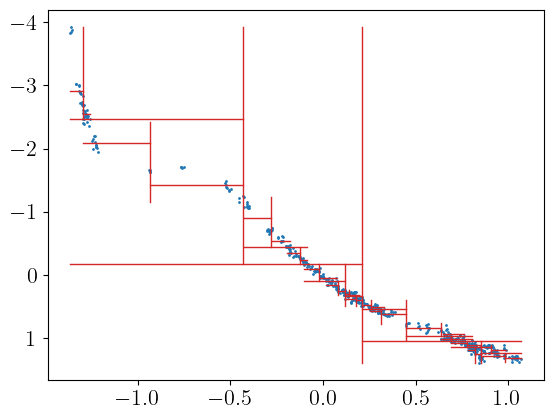

In [22]:
CMD = pd.read_csv('SYNTHETIC_CMDs/Gen2/SCALED/' + targets.file.values[213])

color = 'bprp'
mag = 'v'

X = CMD[color].values
Y = CMD[mag].values

if ((color=='bprp')&(mag=='v')):
    X = X[~np.isnan(Y)]
    Y = Y[~np.isnan(Y)]
else:
    X = X[~np.isnan(X)]
    Y = Y[~np.isnan(Y)]

nPoints = X.shape[0]

x, y = points_QuadTree(X,Y,nPoints)
p = Points(x, y)
plt.scatter(x,y, s=1)
plt.gca().invert_yaxis()

sX, sY, min_sX, max_sX, min_sY, max_sY = QuadTree_(p,3, 50, 50)
s = np.append(sX, sY)

for i in range(0,len(sY)):
    x = [min_sY[i],max_sY[i]]
    y = [sY[i],sY[i]]
    plt.plot(x, y, lw=1, alpha=1, color='C3')

for i in range(0,len(sX)):
    x = [sX[i],sX[i]]
    y = [min_sX[i],max_sX[i]]
    plt.plot(x, y, lw=1, alpha=1, color='C3')

